In [82]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob
import os

import matplotlib.pyplot as plt
import pandas as pd
import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [84]:
perturbed_files = './SampleSortCali/all_perturbed_cali'
sorted_files = './SampleSortCali/all_sorted_cali'
reversed_files = './SampleSortCali/all_reverse_cali'
random_files = './SampleSortCali/all_random_cali'

# Load all the .cali files from the directories into Thicket
tk_perturbed = th.Thicket.from_caliperreader(perturbed_files)
tk_sorted = th.Thicket.from_caliperreader(sorted_files)
tk_reversed = th.Thicket.from_caliperreader(reversed_files)
tk_random = th.Thicket.from_caliperreader(random_files)

(2/2) Creating Thicket: 100%|██████████████████████████████████████████████████████████| 69/69 [00:03<00:00, 20.39it/s]


In [85]:
input_sizes = [2**16, 2**18, 2**20, 2**22, 2**24, 2**26, 2**28]
input_types = ['Perturbed', 'Sorted', 'Reversed', 'Random']
processes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
metrics = ["Avg time/rank", "Max time/rank", "Min time/rank"]
components = ["comm", "comp_large", "main"]

In [86]:
df_perturbed = tk_perturbed.dataframe
df_sorted = tk_sorted.dataframe
df_reversed = tk_reversed.dataframe
df_random = tk_random.dataframe
print("Available columns:", df_perturbed.columns)

Available columns: Index(['nid', 'spot.channel', 'Min time/rank', 'Max time/rank',
       'Avg time/rank', 'Total time', 'Variance time/rank',
       'Min time/rank (exc)', 'Max time/rank (exc)', 'Avg time/rank (exc)',
       'Total time (exc)', 'Calls/rank (min)', 'Calls/rank (avg)',
       'Calls/rank (max)', 'Calls/rank (total)', 'name'],
      dtype='object')


In [87]:
tk_perturbed.metadata_column_to_perfdata("num_procs")
tk_perturbed.metadata_column_to_perfdata("input_size")
tk_perturbed.metadata_column_to_perfdata("input_type")

tk_random.metadata_column_to_perfdata("num_procs")
tk_random.metadata_column_to_perfdata("input_size")
tk_random.metadata_column_to_perfdata("input_type")

tk_sorted.metadata_column_to_perfdata("num_procs")
tk_sorted.metadata_column_to_perfdata("input_size")
tk_sorted.metadata_column_to_perfdata("input_type")

tk_reversed.metadata_column_to_perfdata("num_procs")
tk_reversed.metadata_column_to_perfdata("input_size")
tk_reversed.metadata_column_to_perfdata("input_type")

# Now df_perturbed should have num_procs, input_size, and input_type columns
df_perturbed = tk_perturbed.dataframe
df_random = tk_random.dataframe
df_sorted = tk_sorted.dataframe
df_reversed = tk_reversed.dataframe

In [88]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [91]:
output_dir = "scaling_plots/samplesort/strong_scaling"

In [92]:
input_types_dataframes = {
    'Perturbed': df_perturbed,
    'Random': df_random,
    'Reversed': df_reversed,
    'Sorted': df_sorted
}


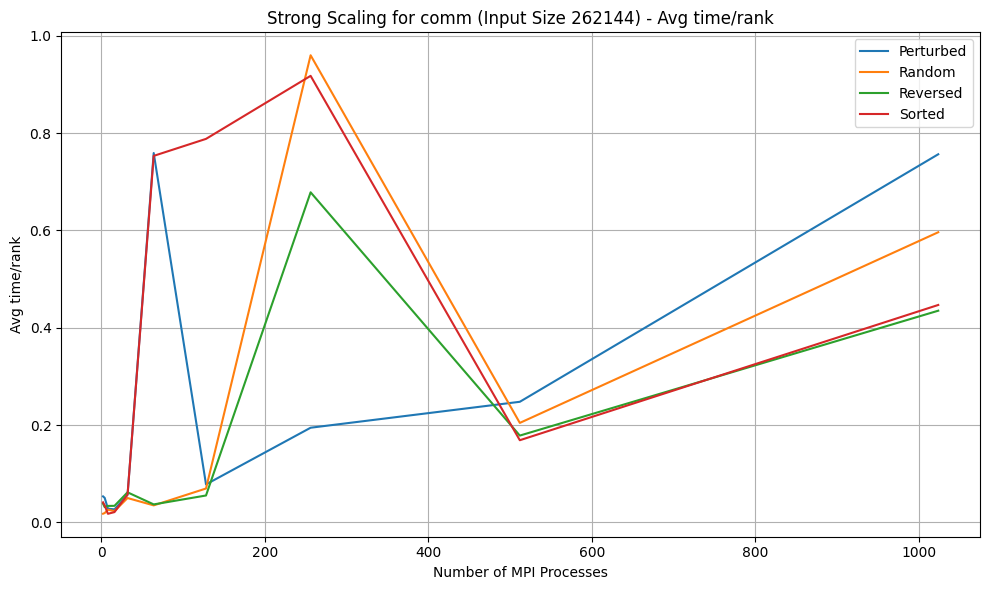

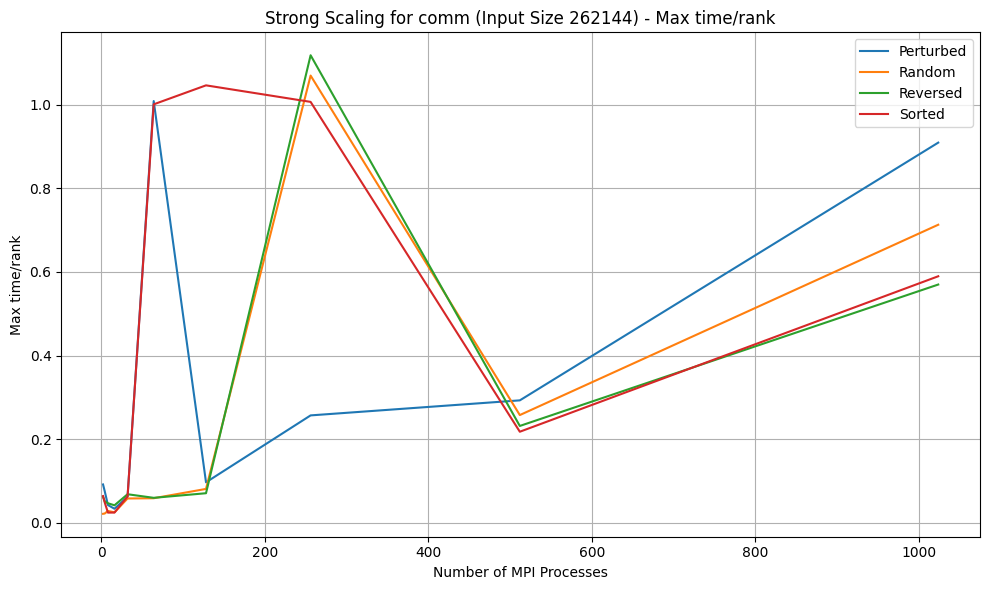

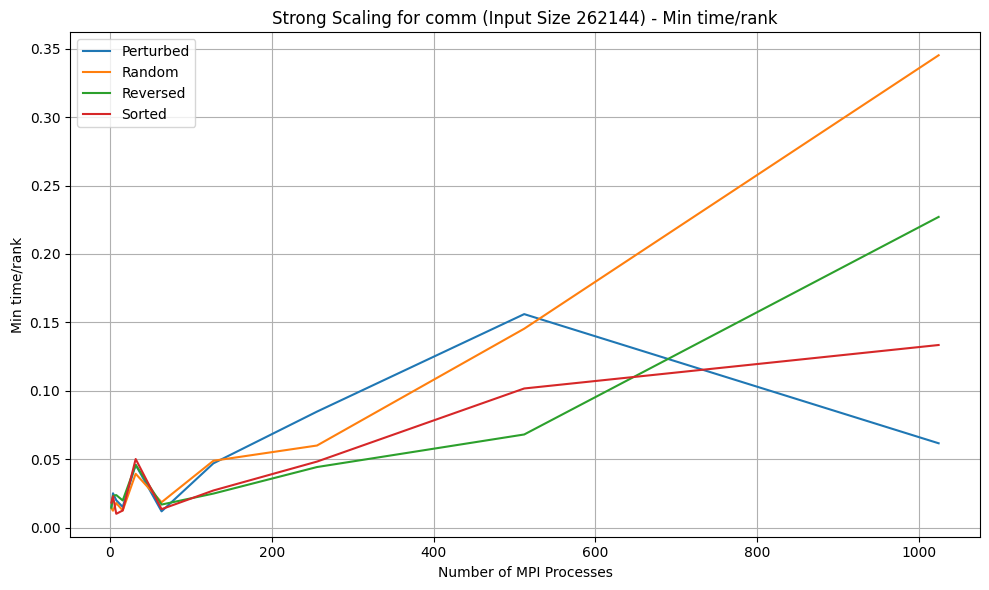

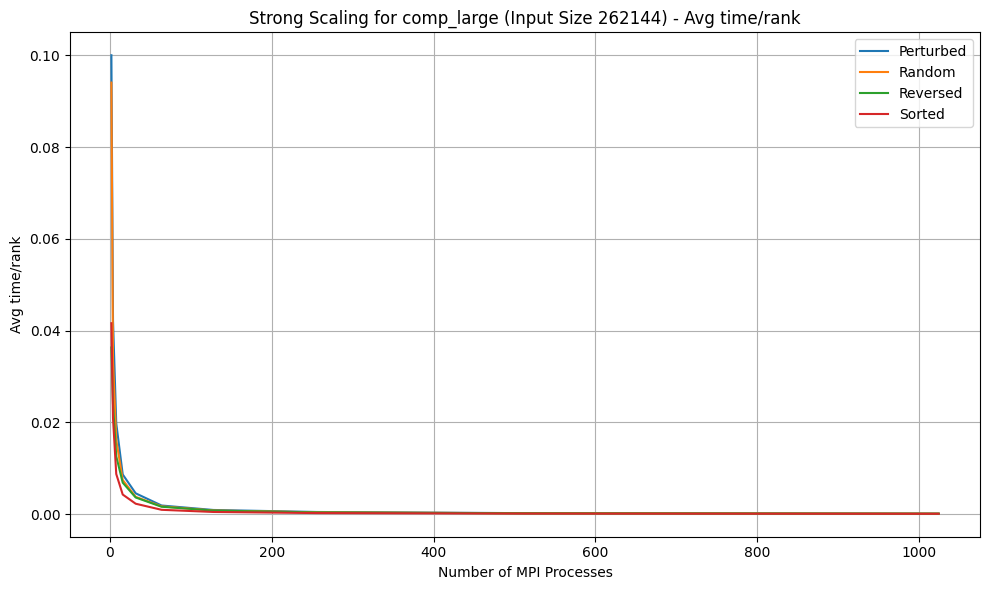

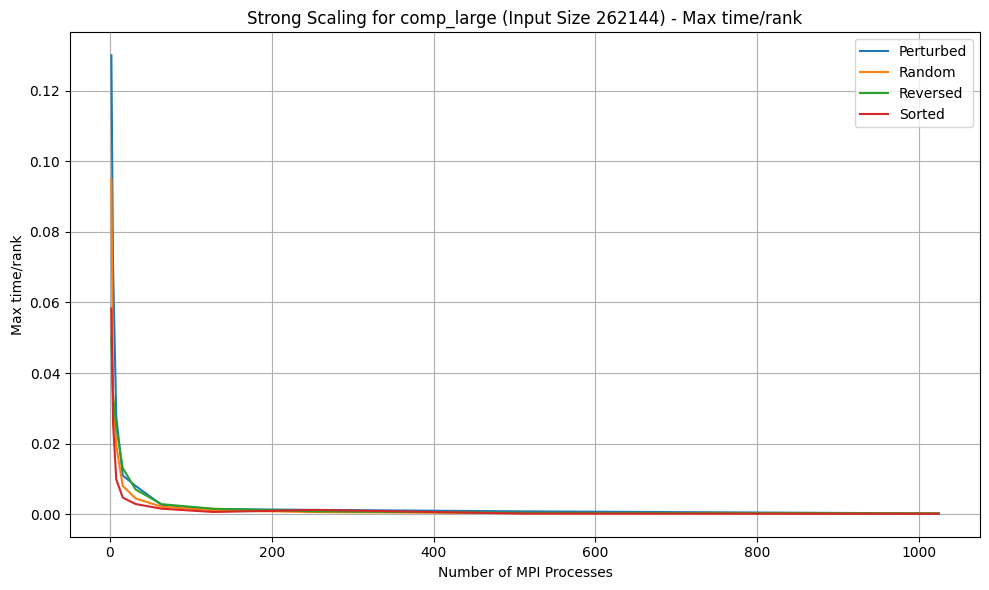

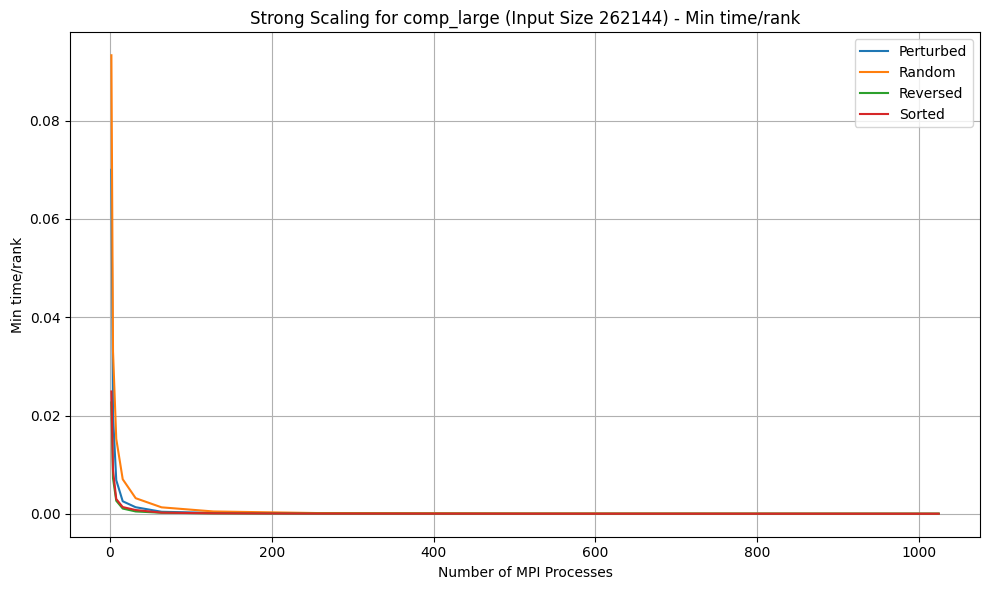

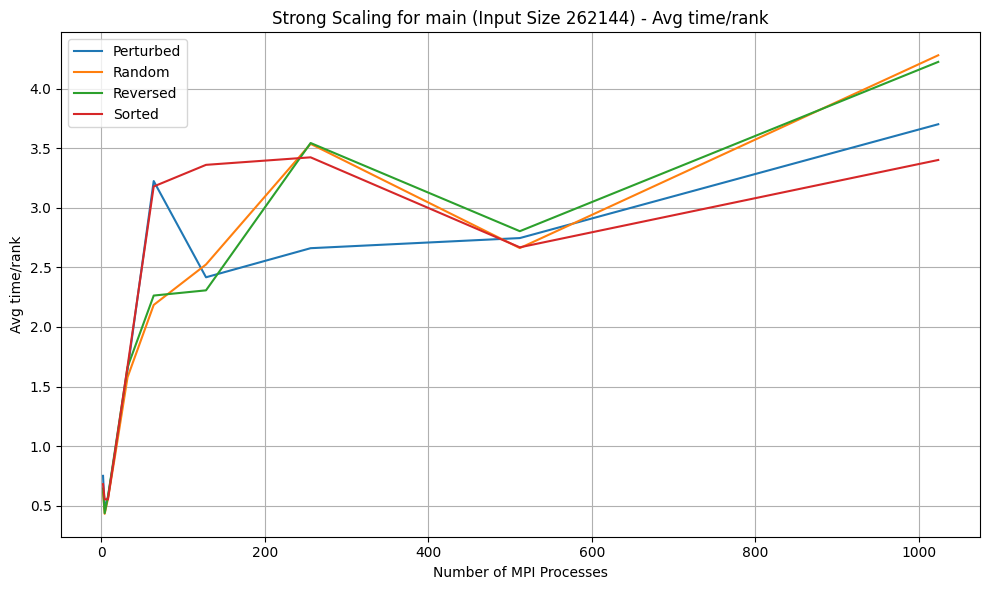

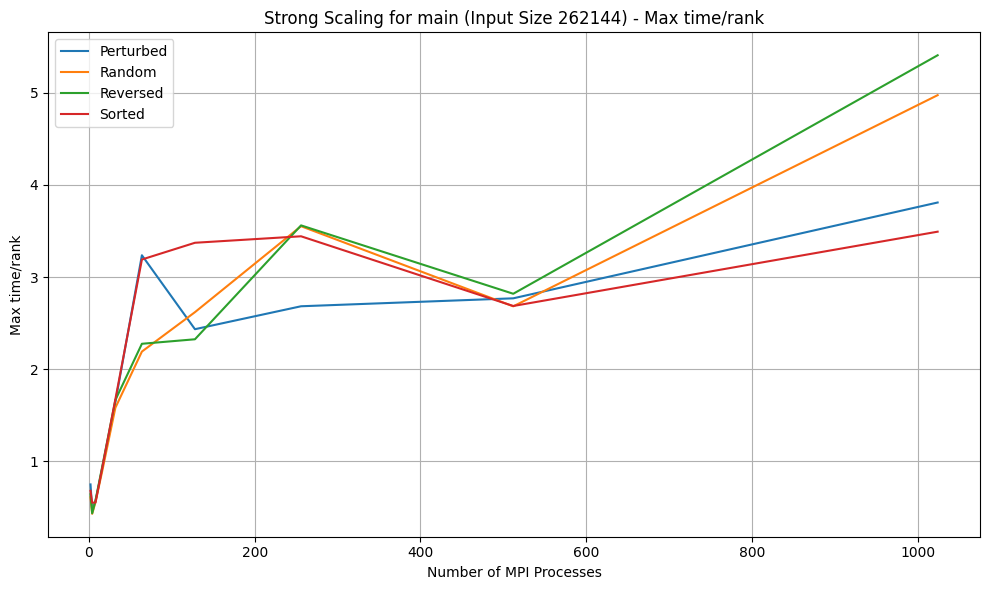

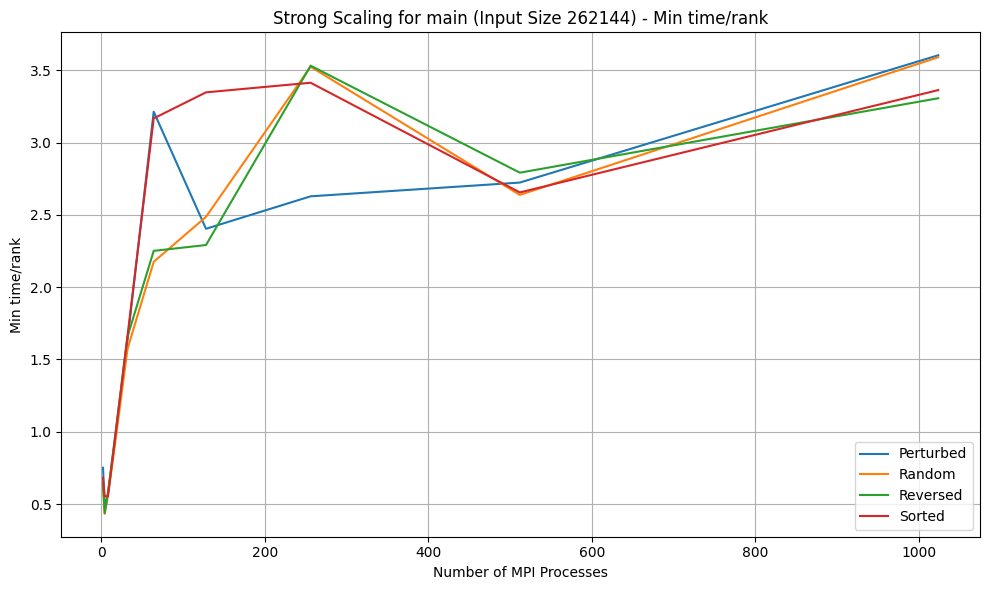

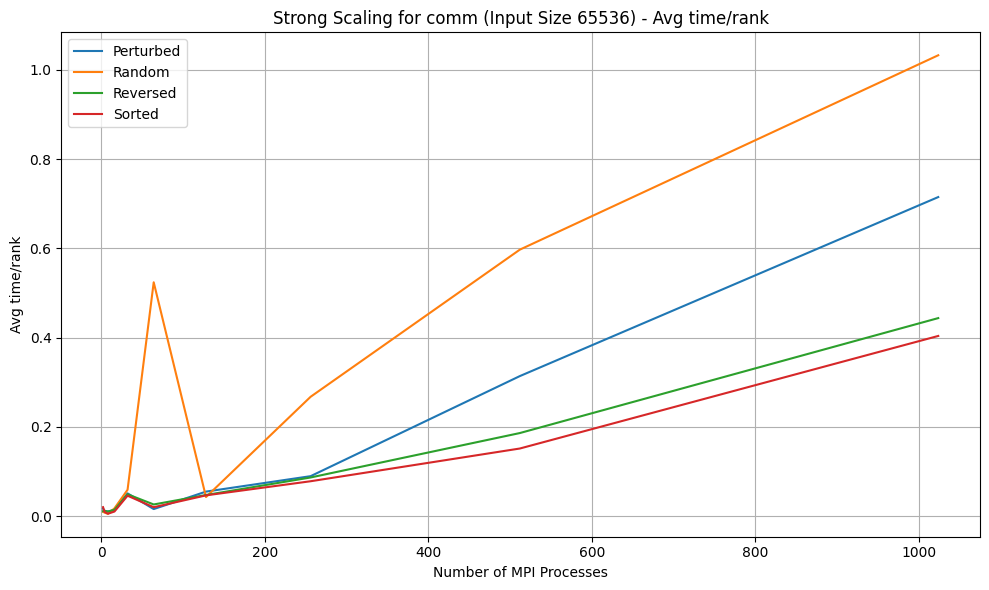

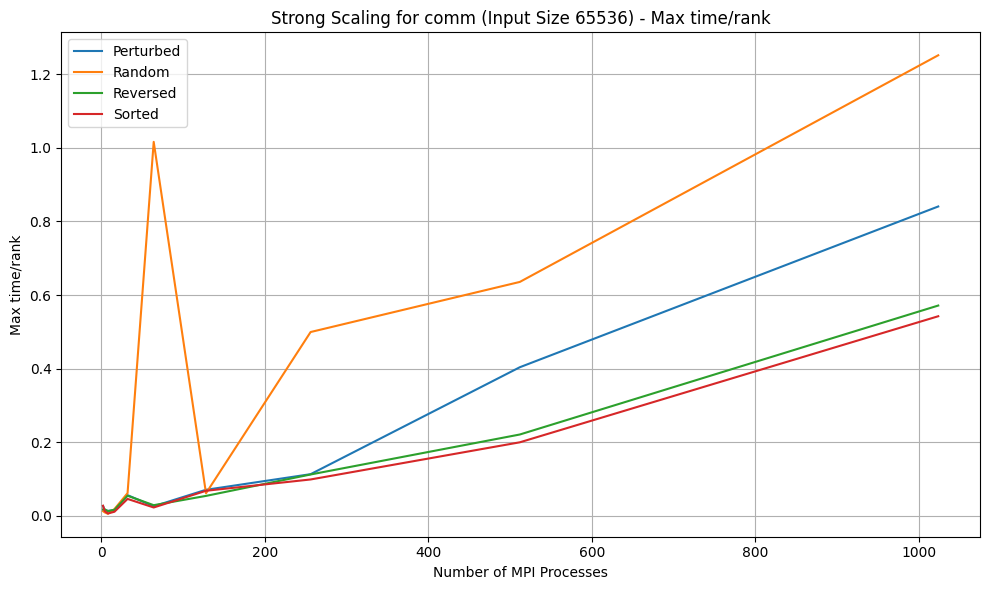

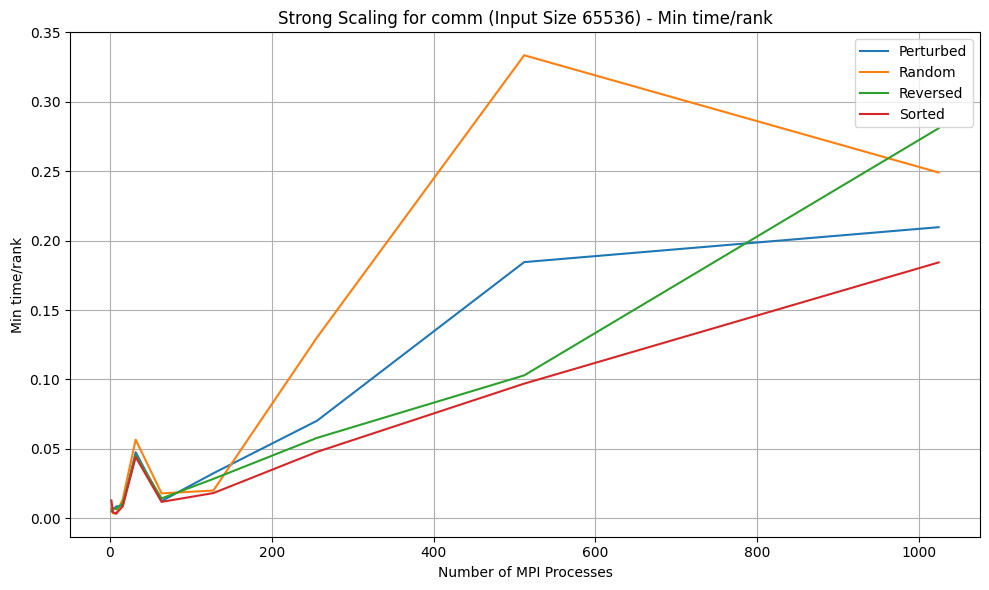

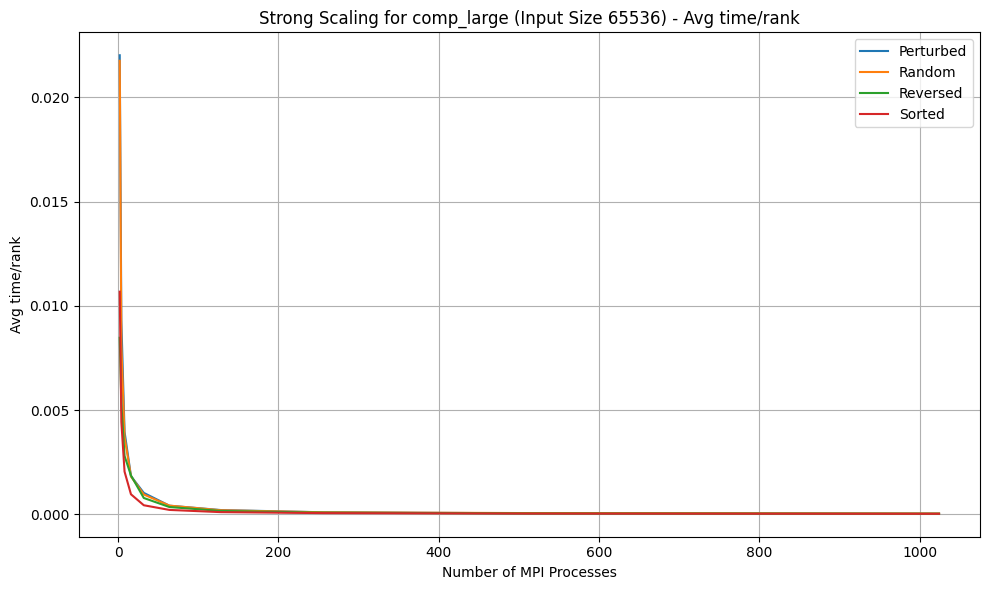

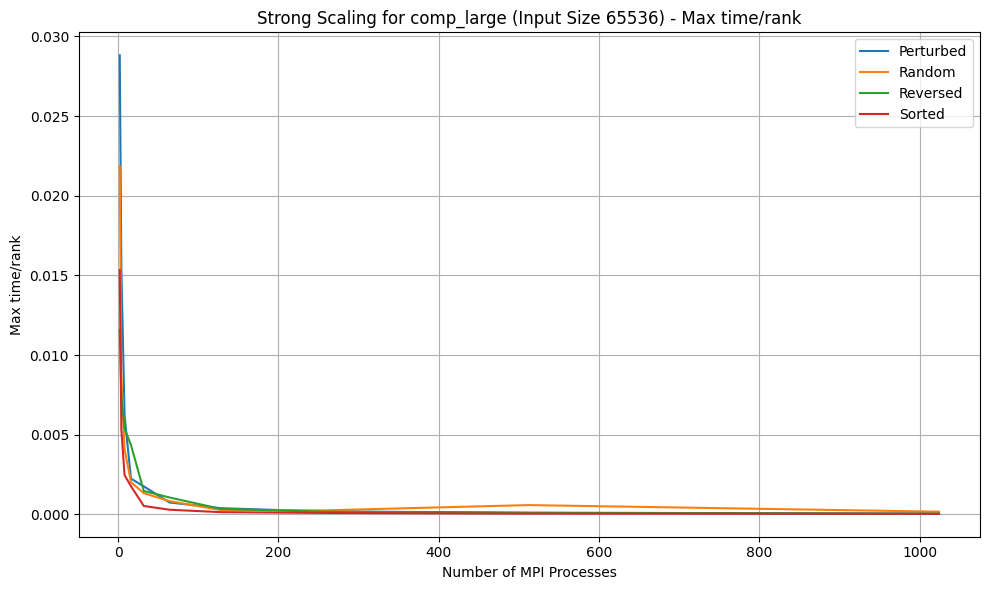

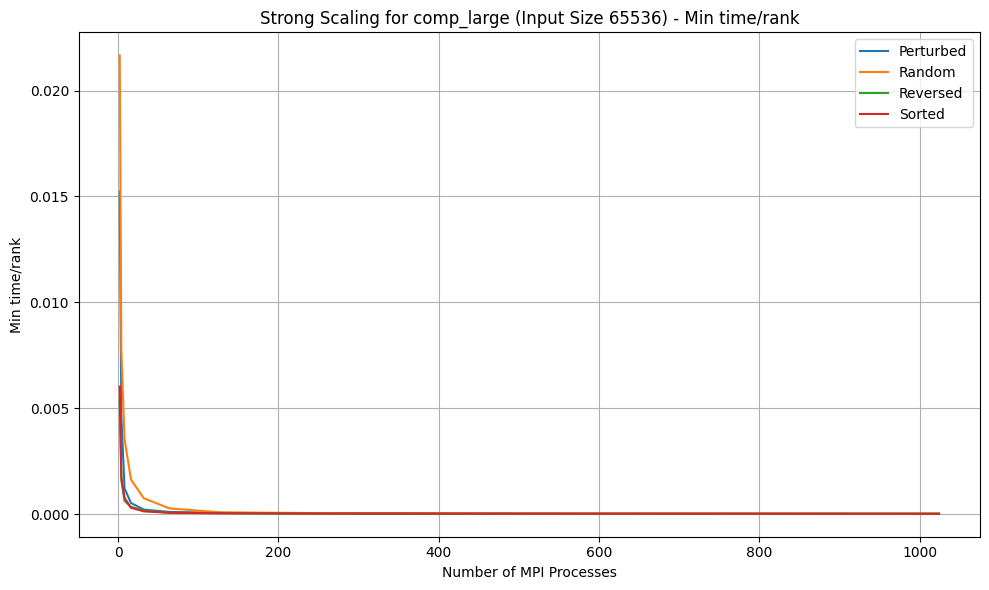

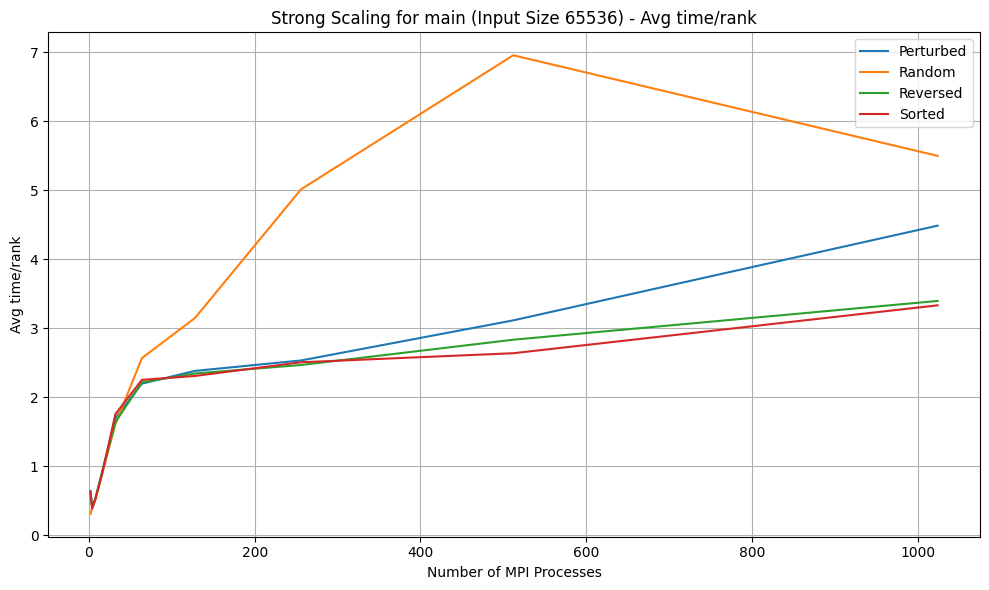

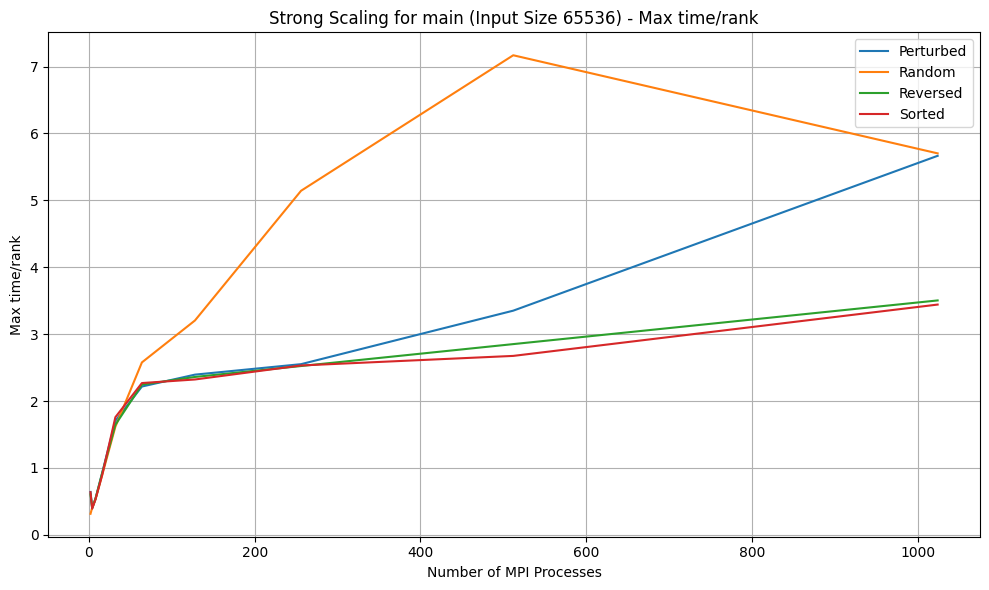

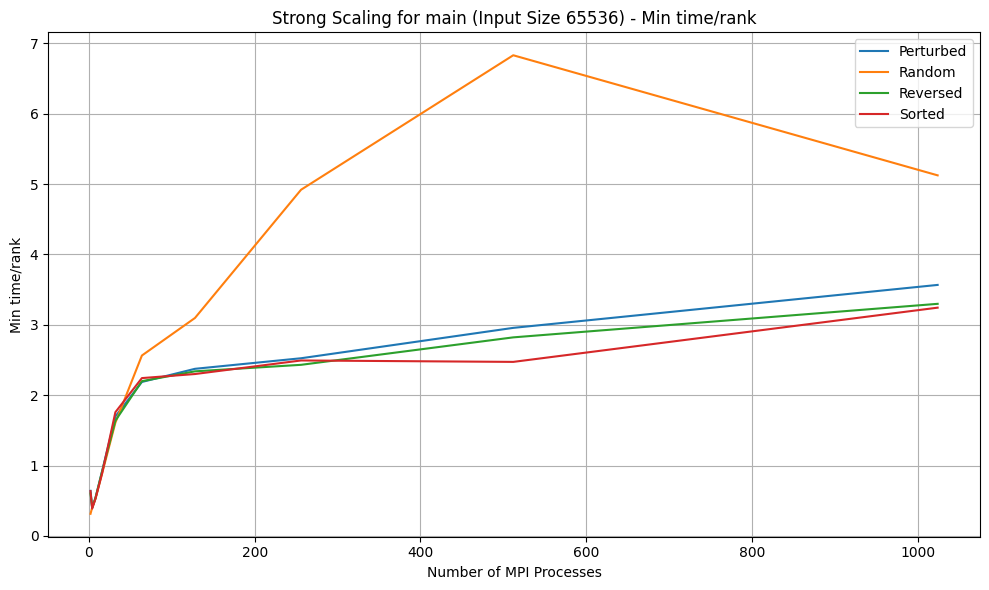

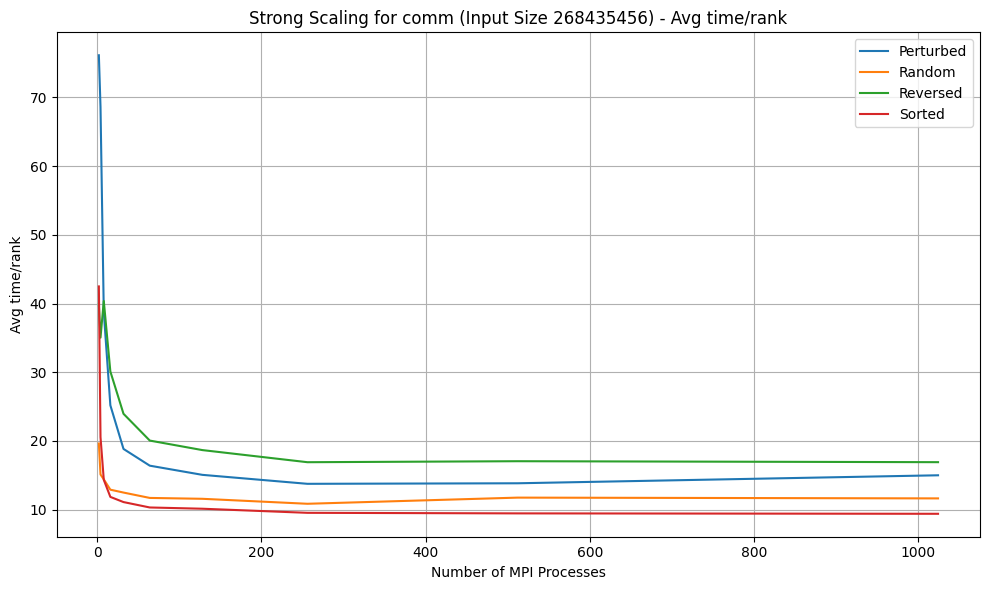

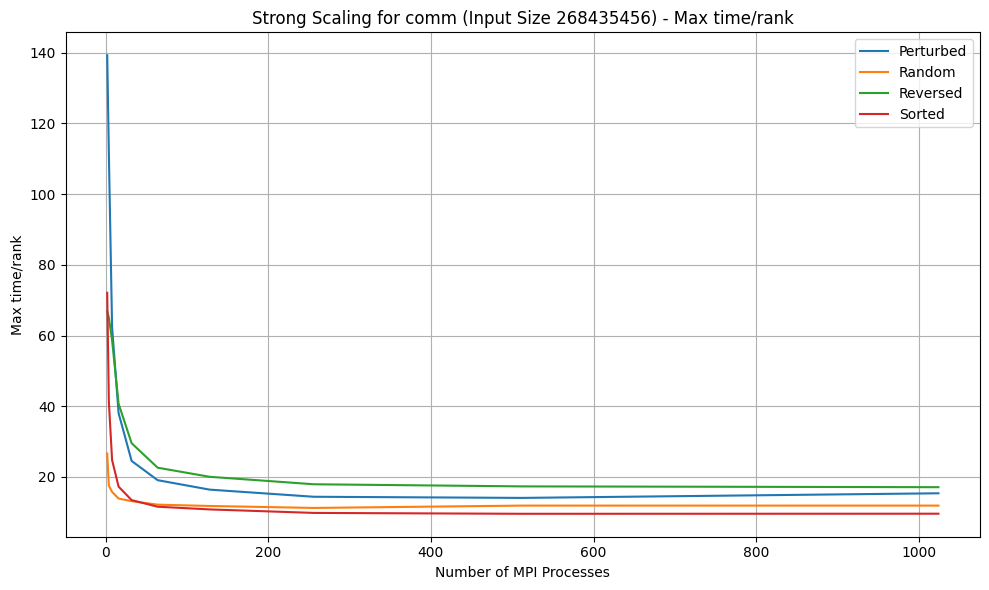

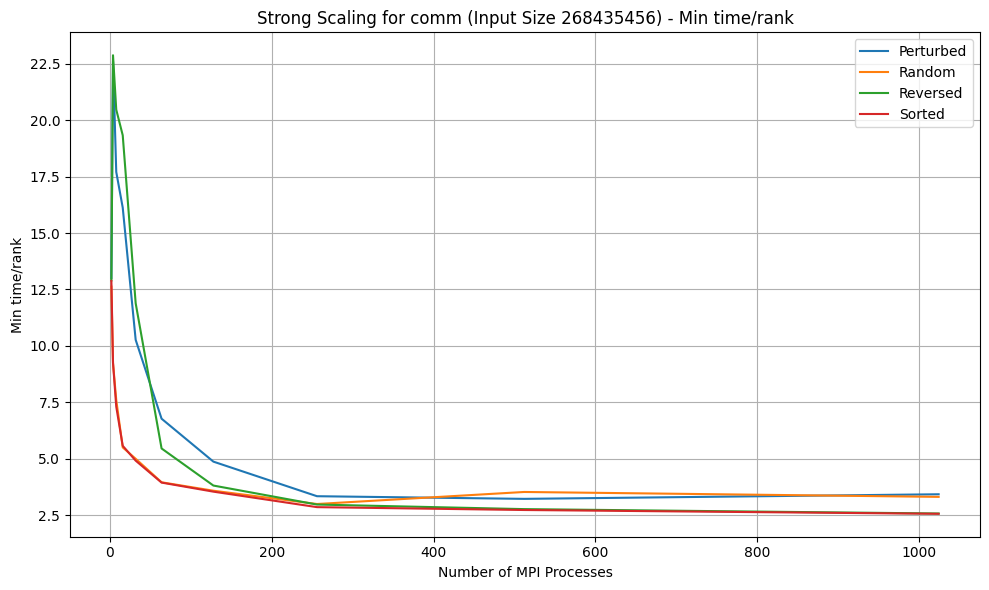

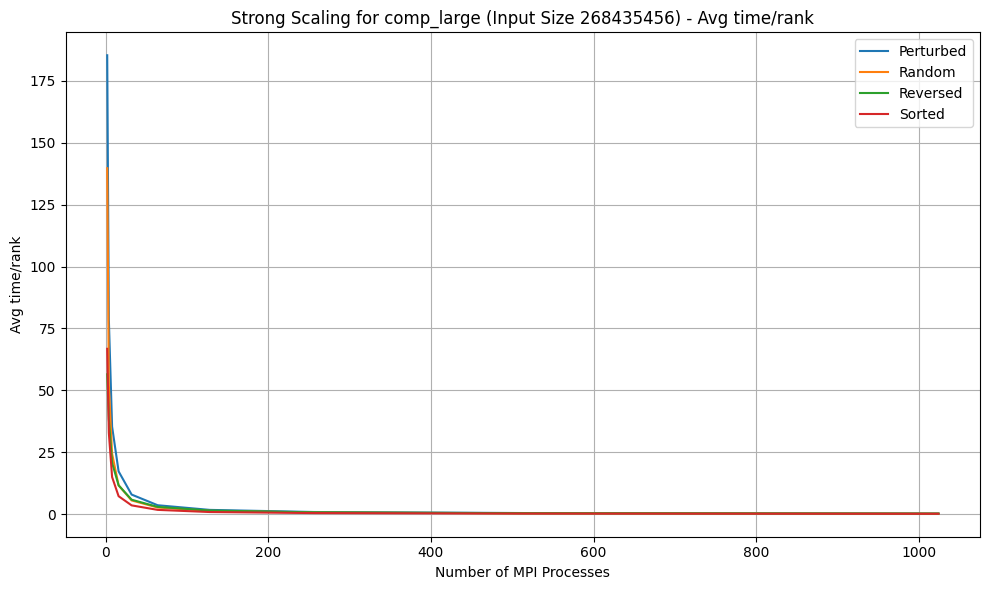

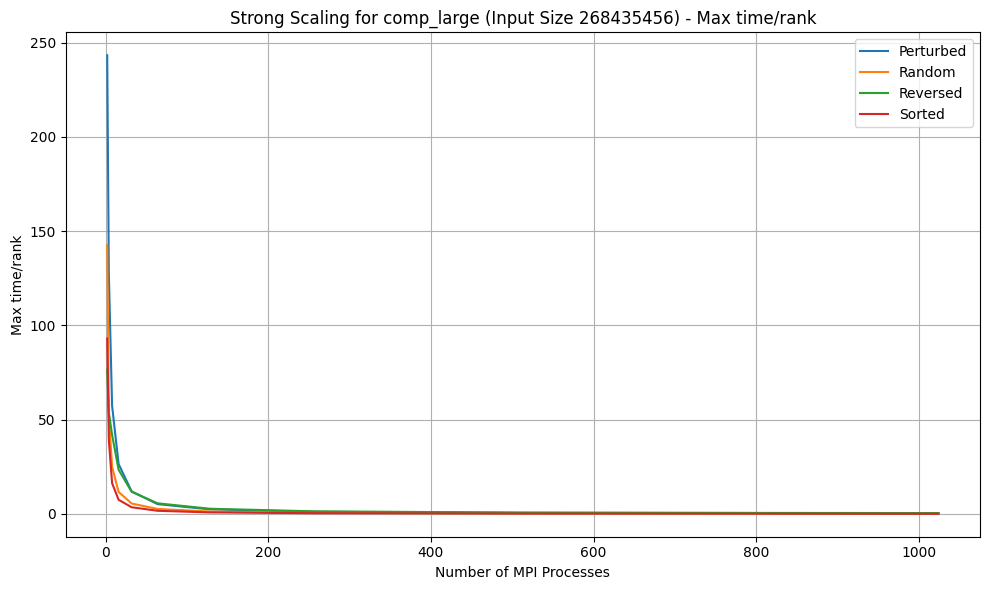

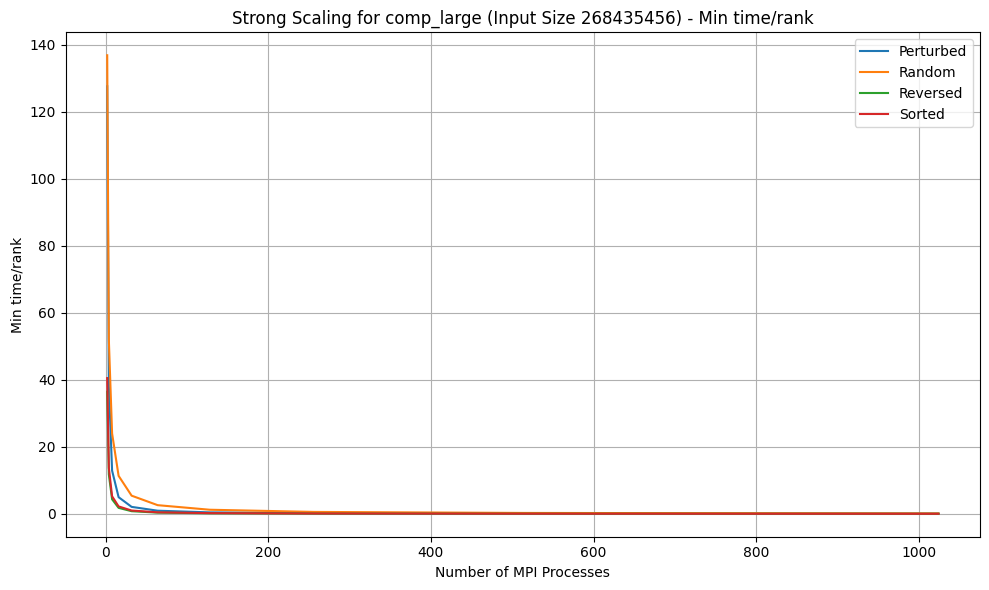

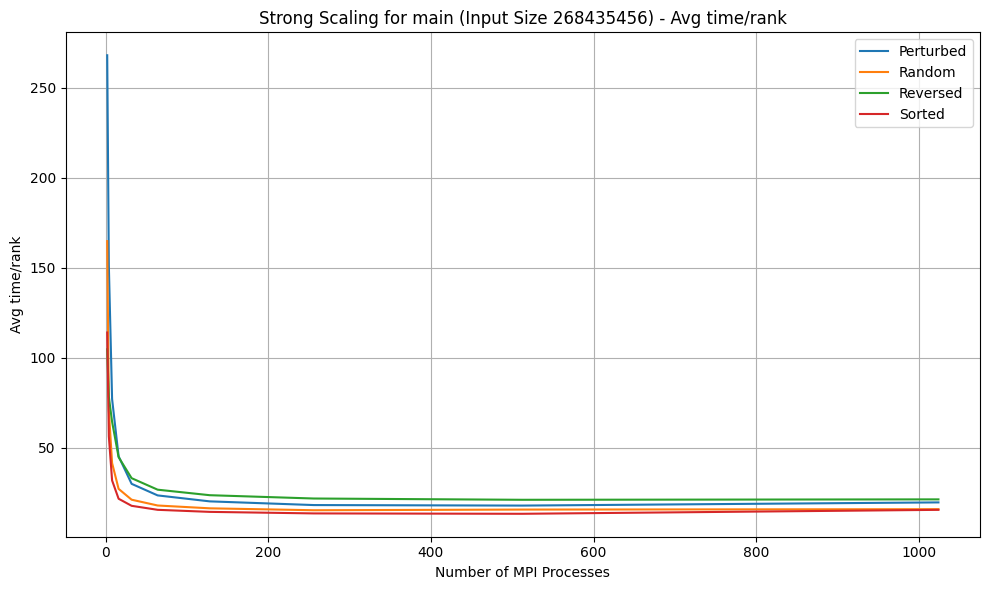

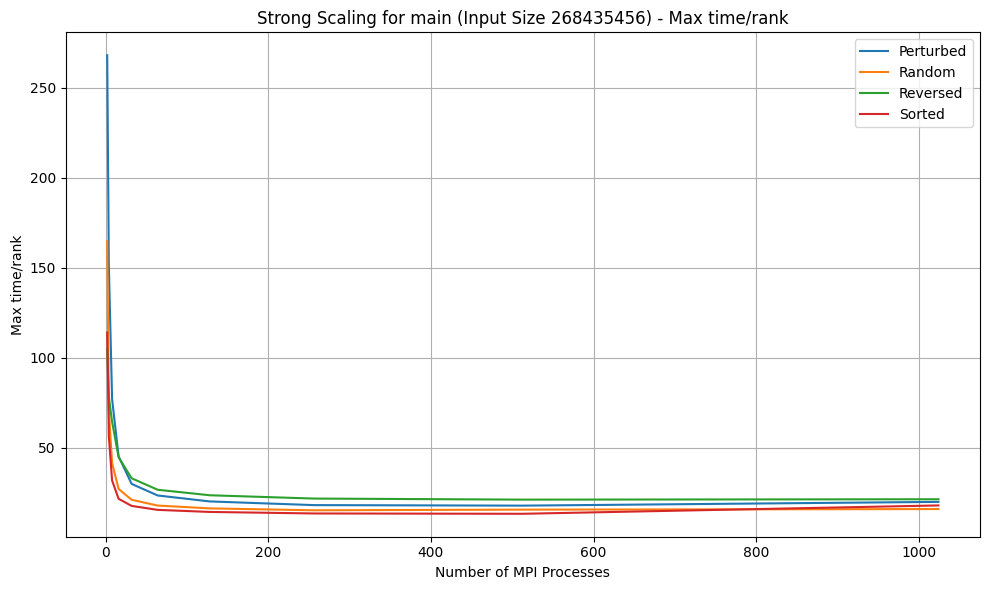

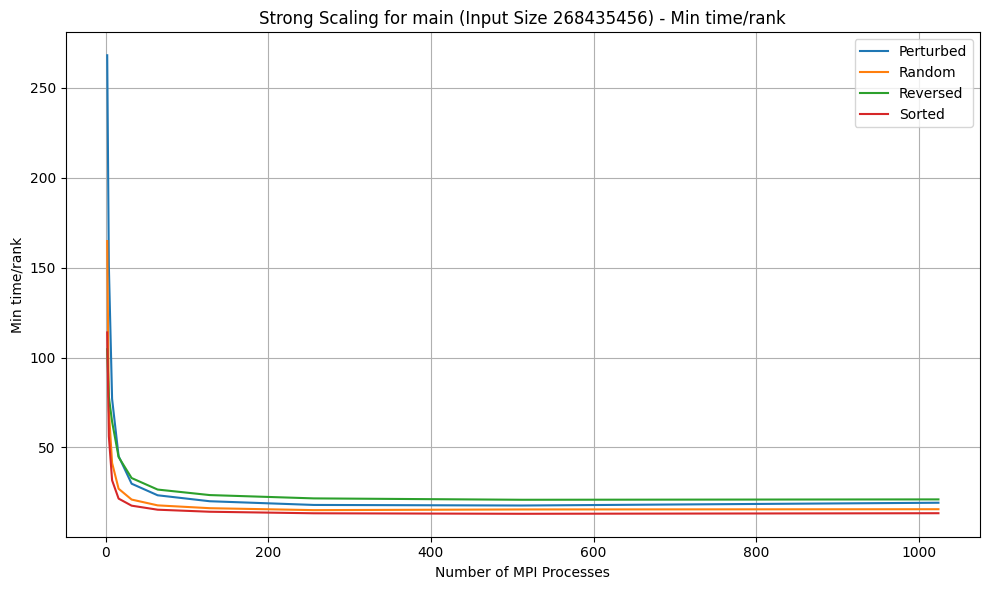

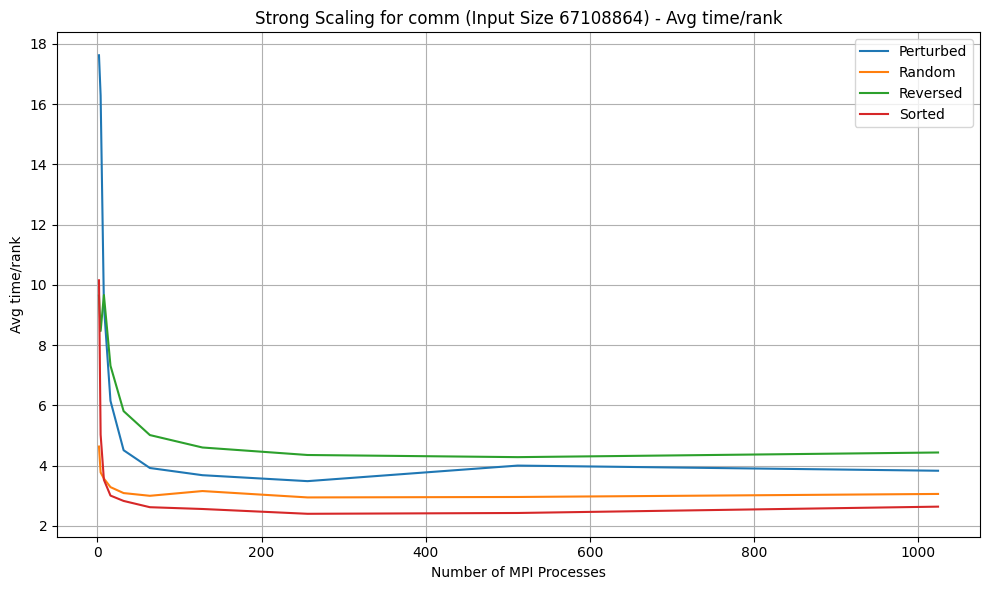

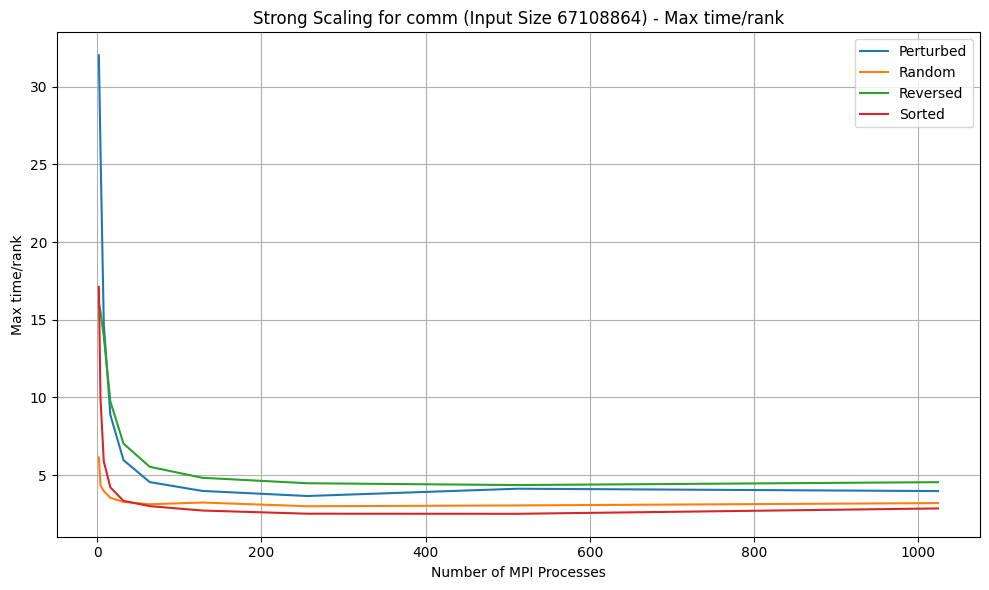

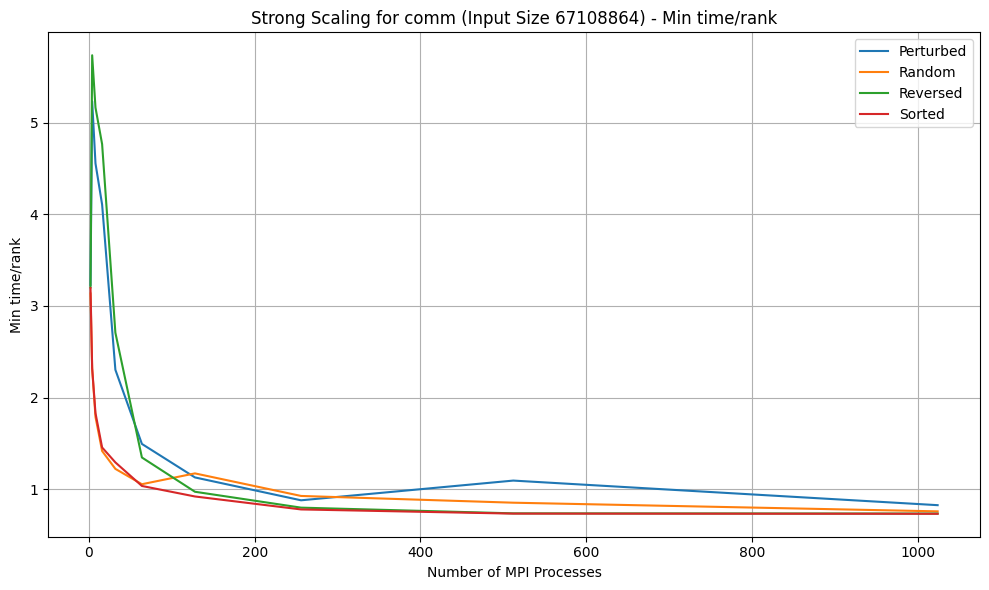

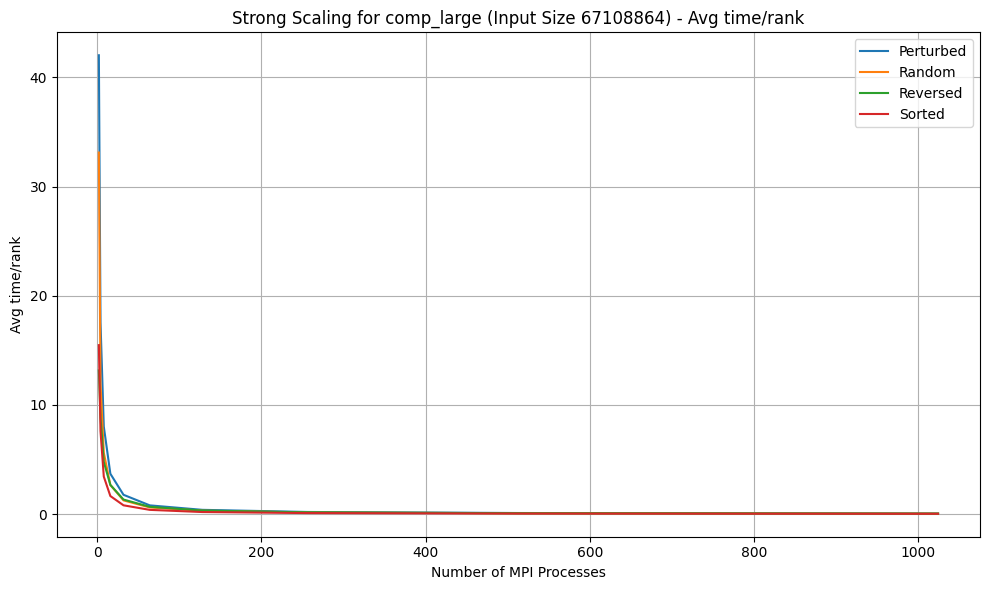

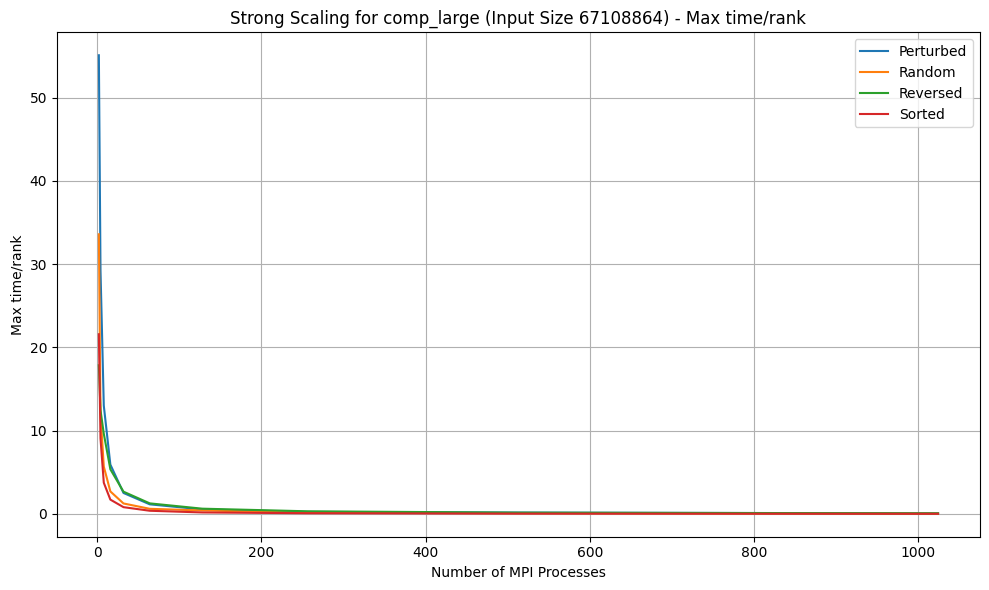

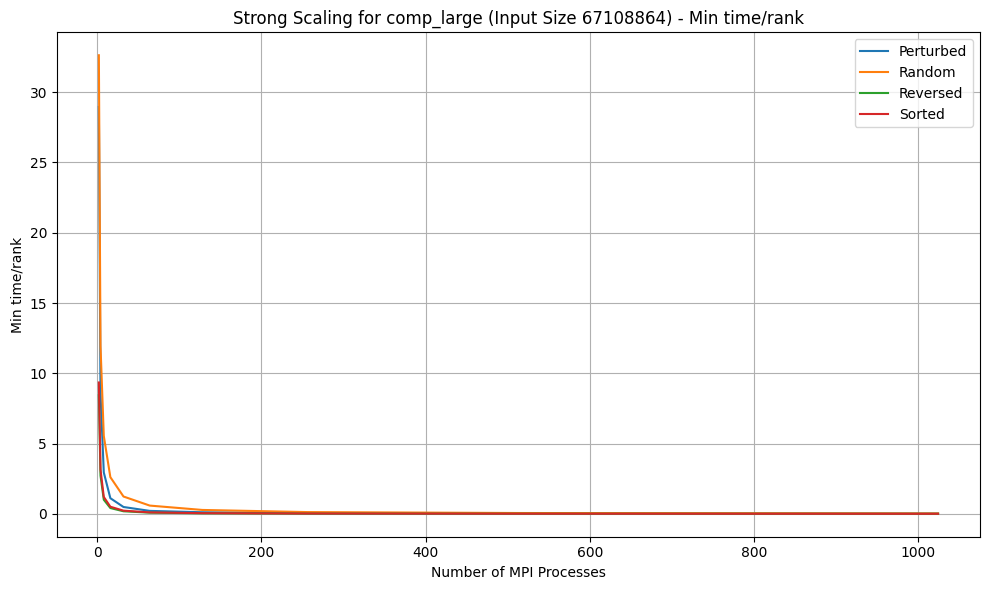

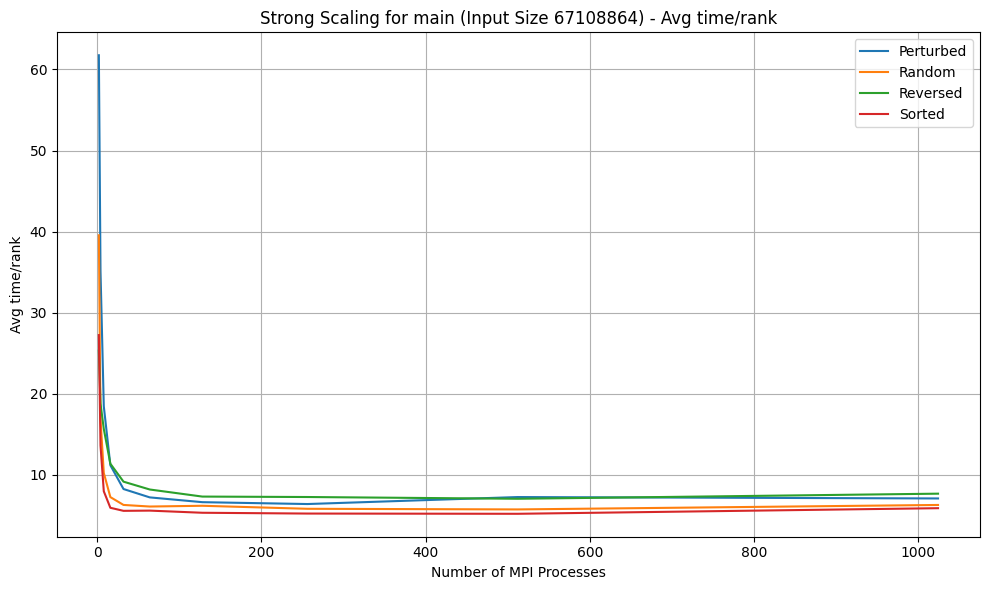

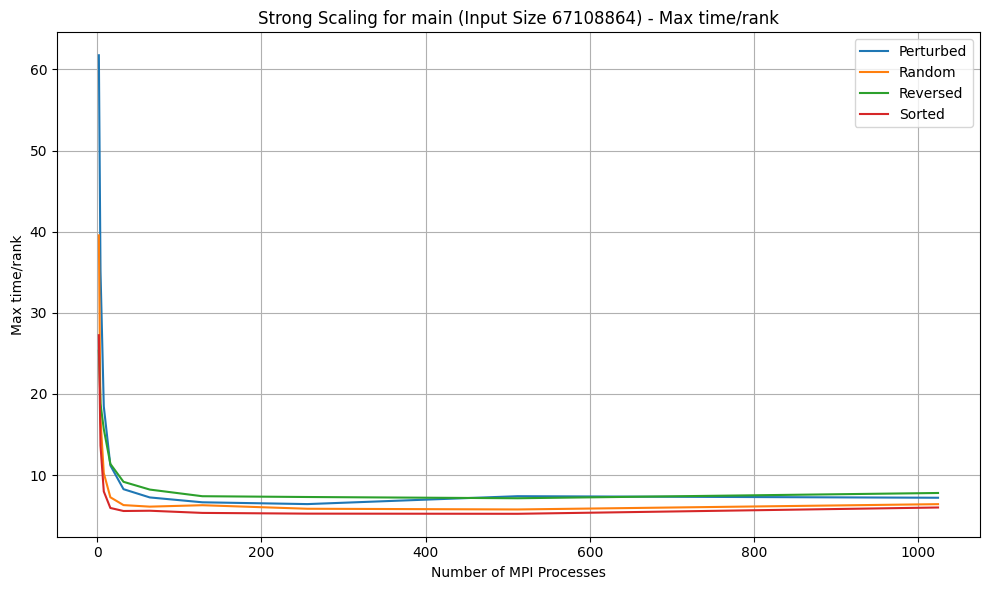

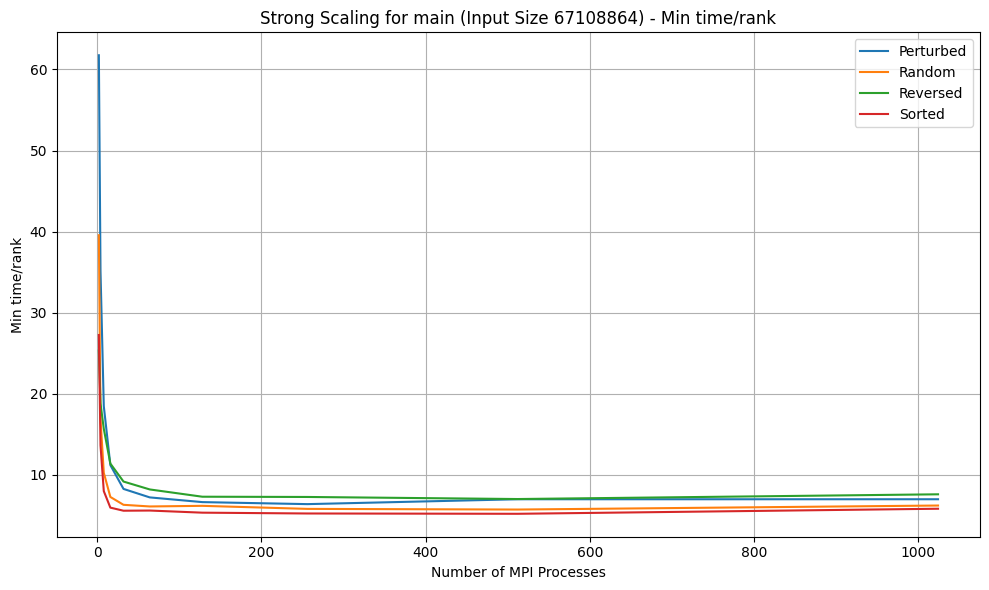

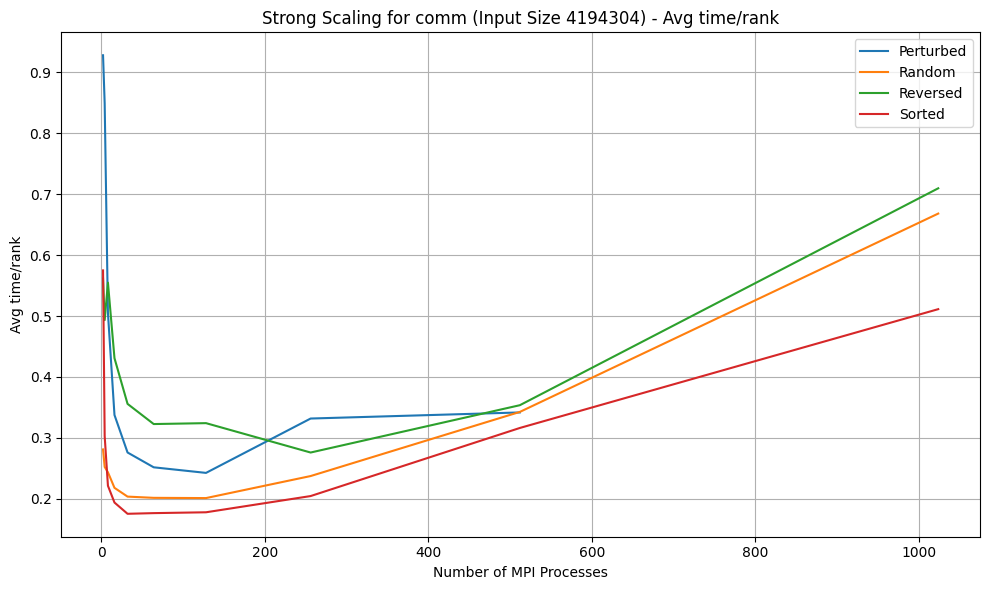

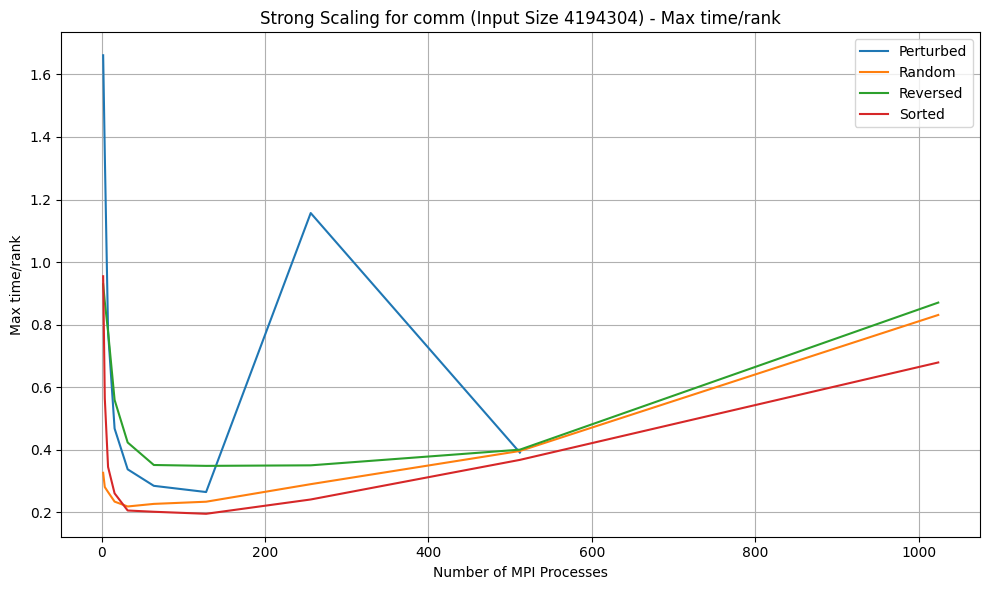

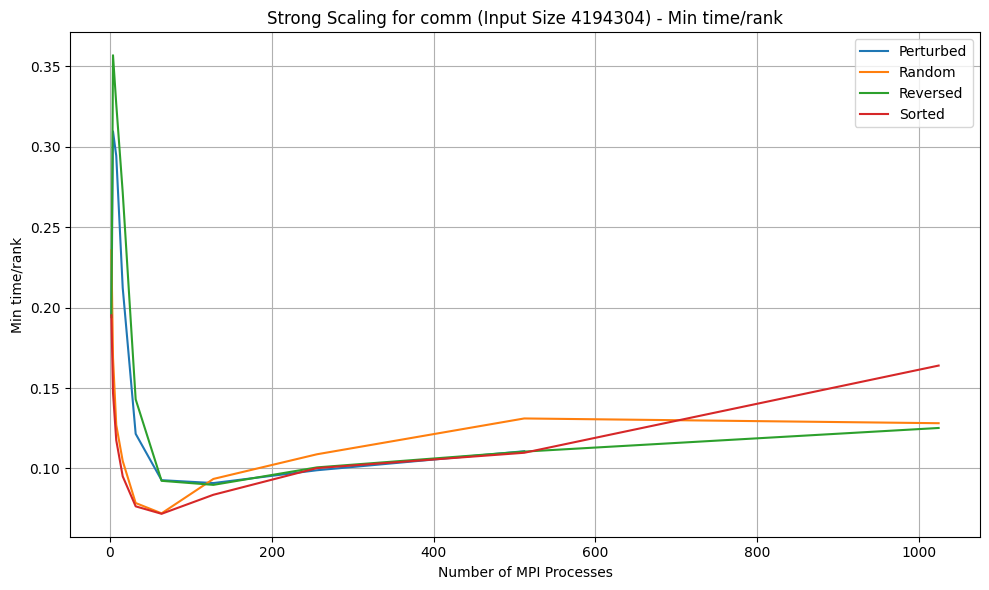

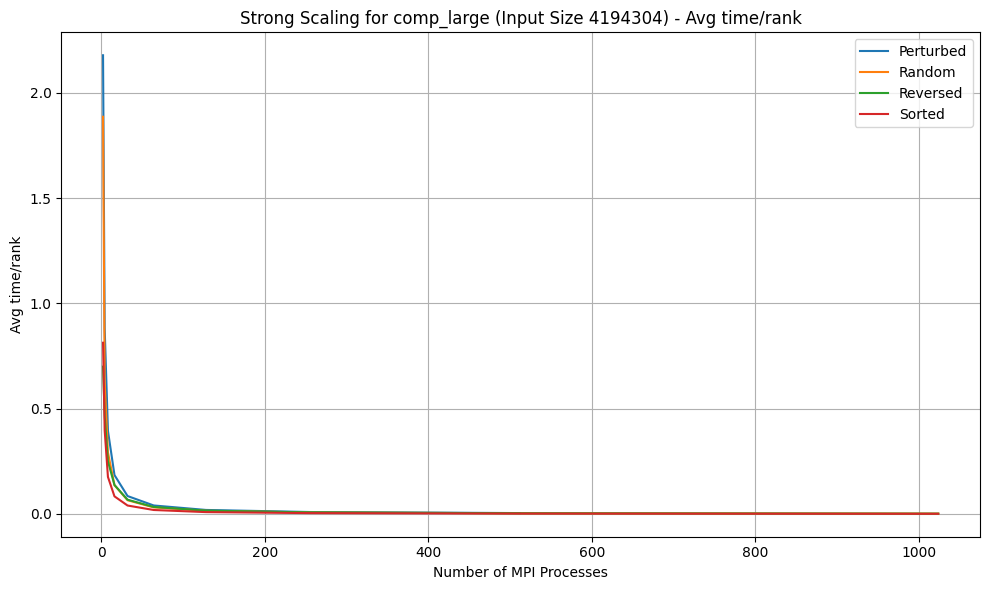

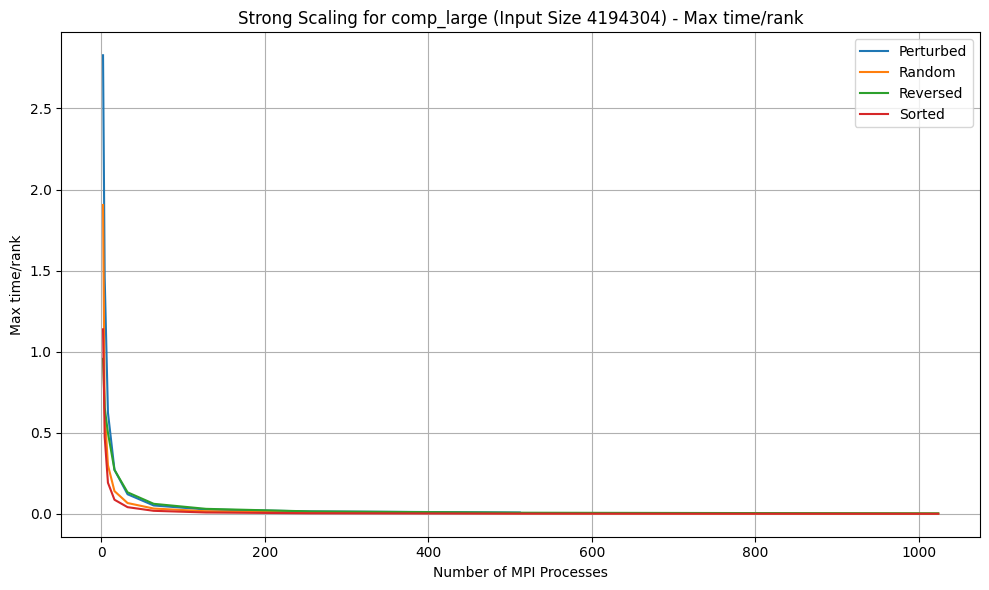

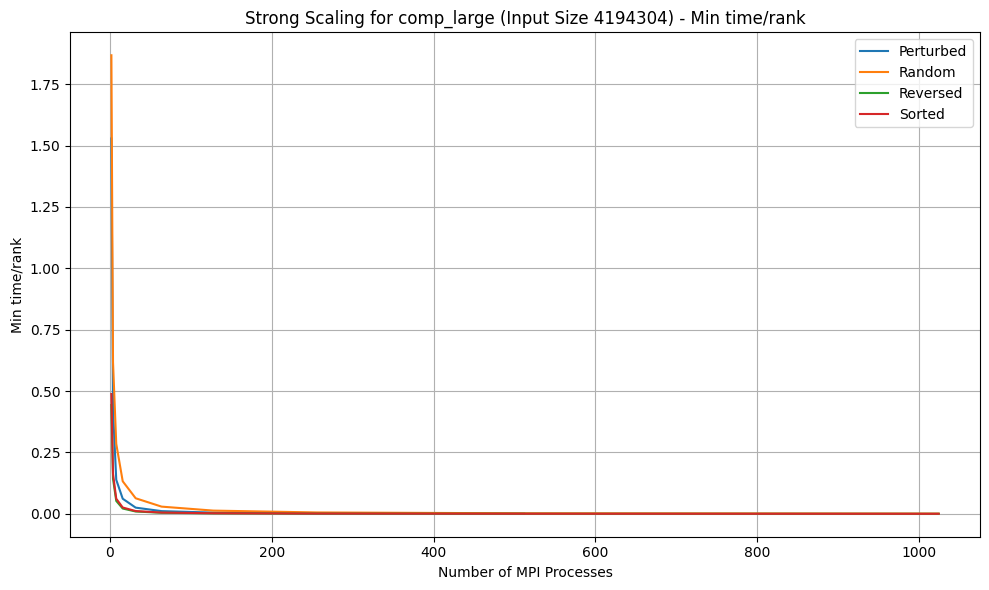

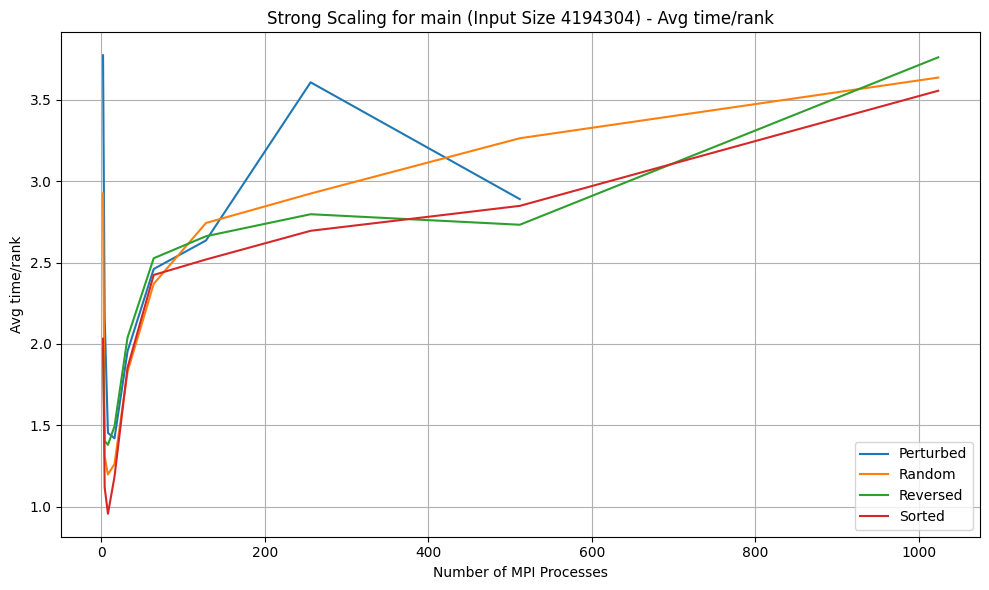

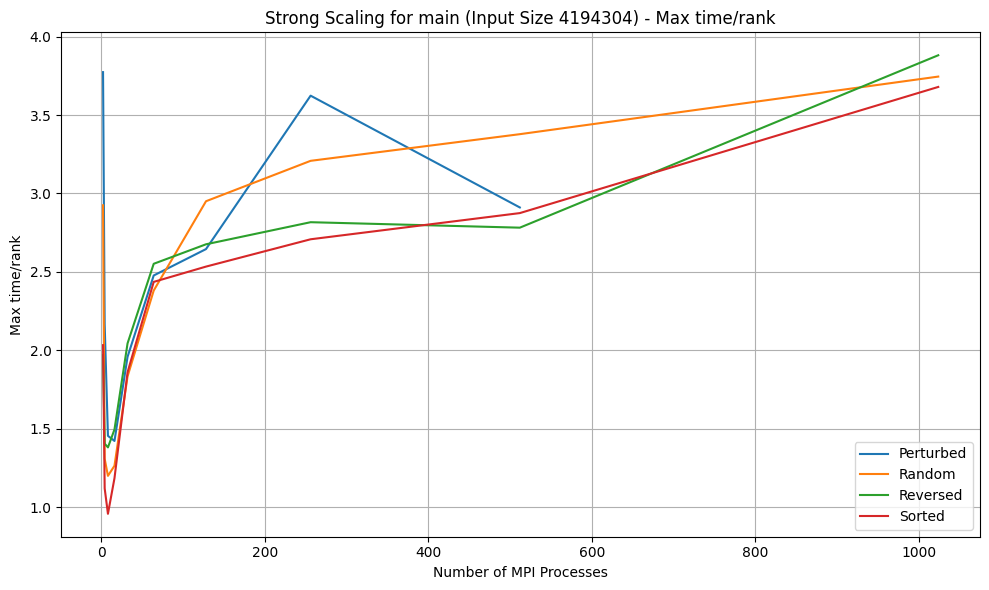

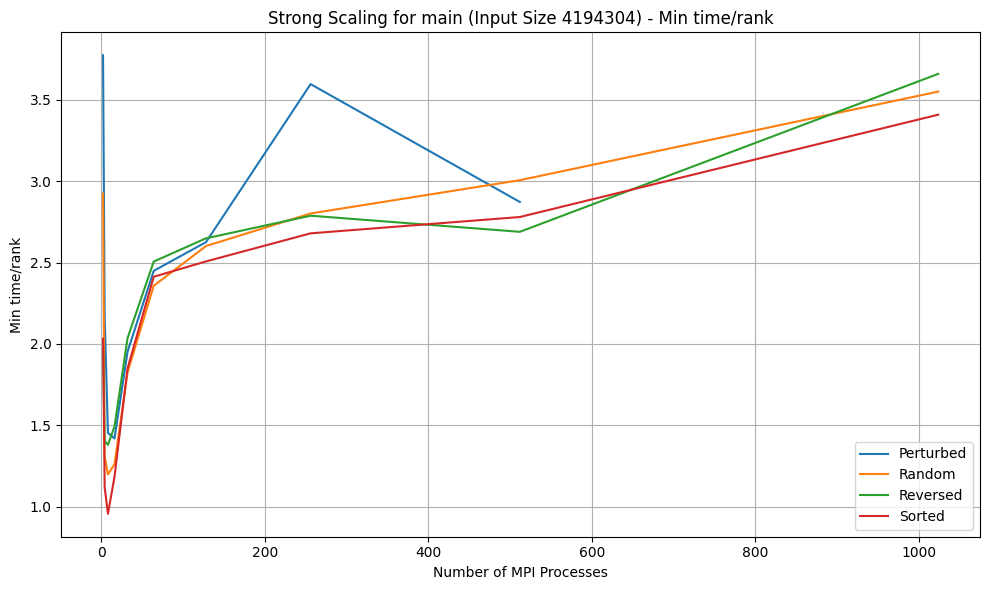

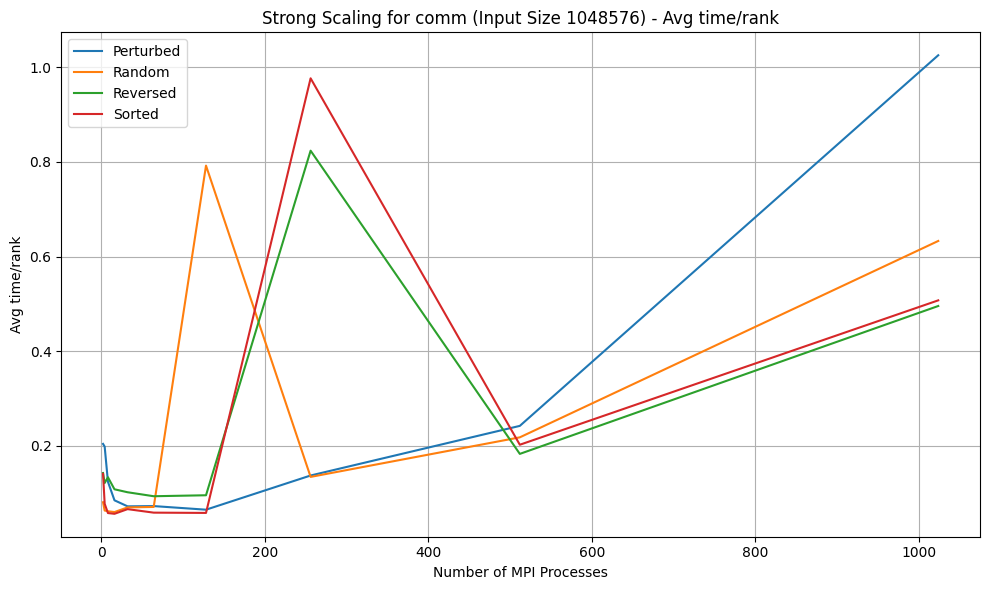

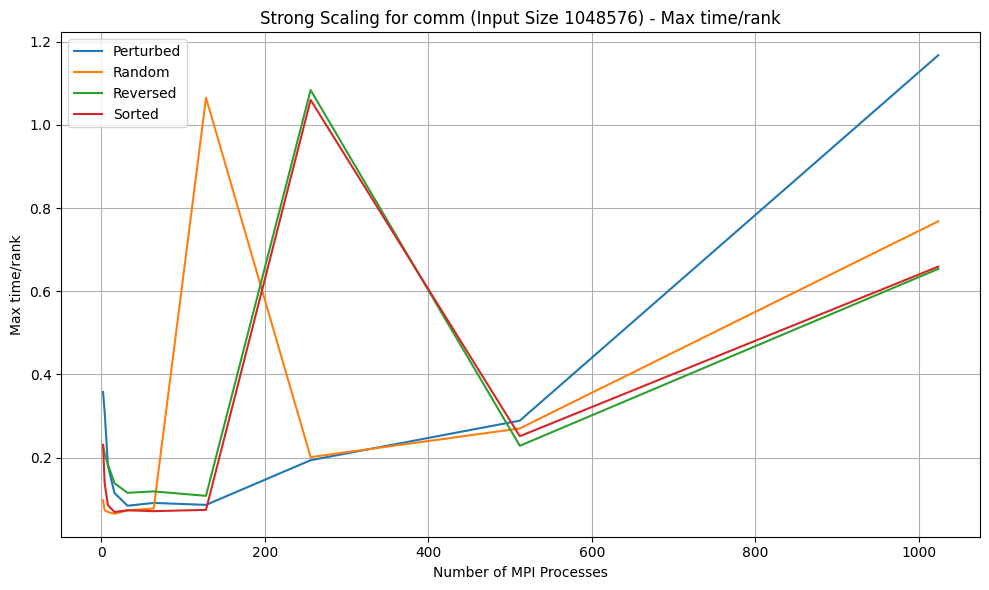

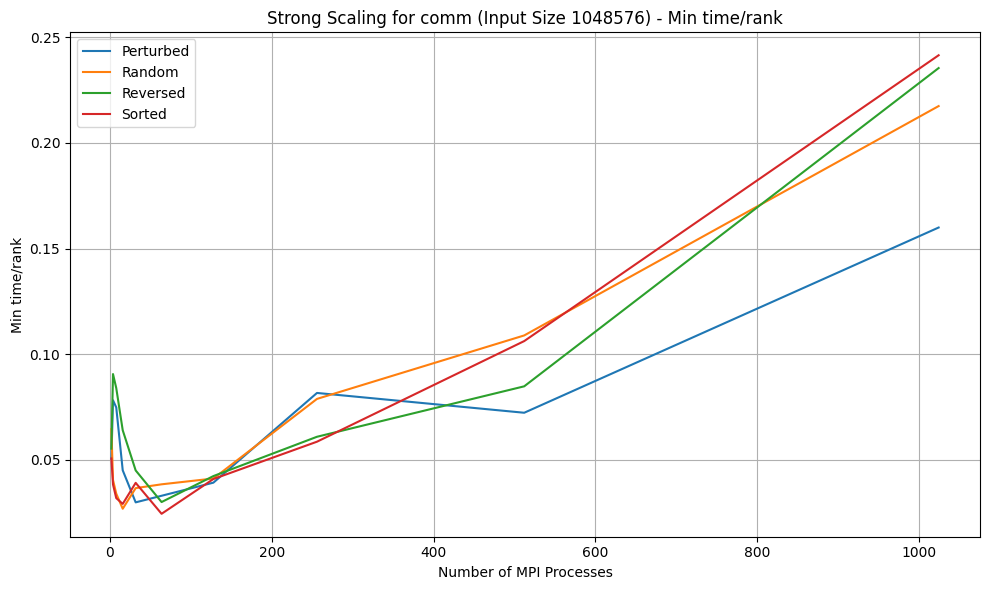

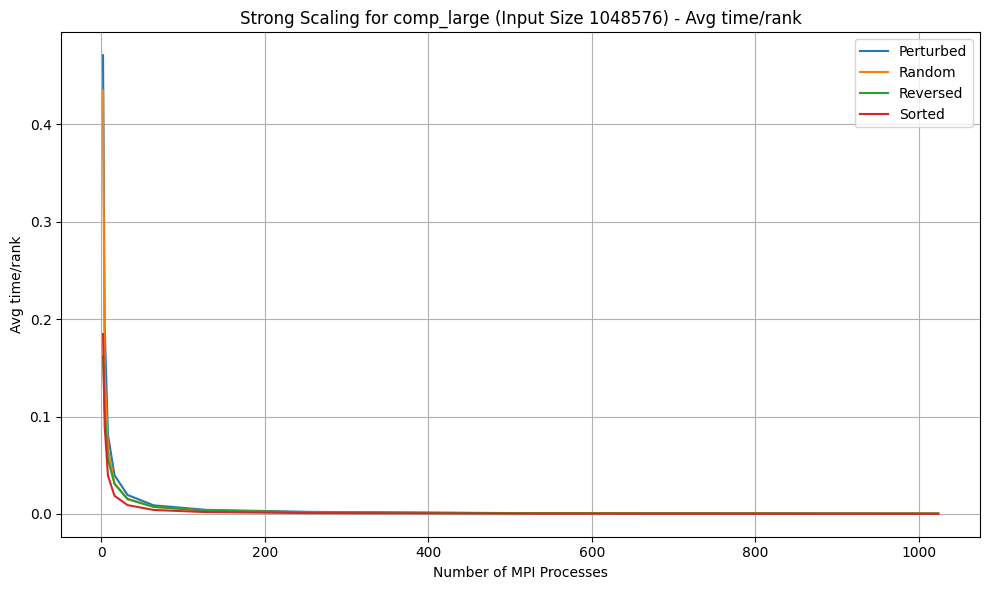

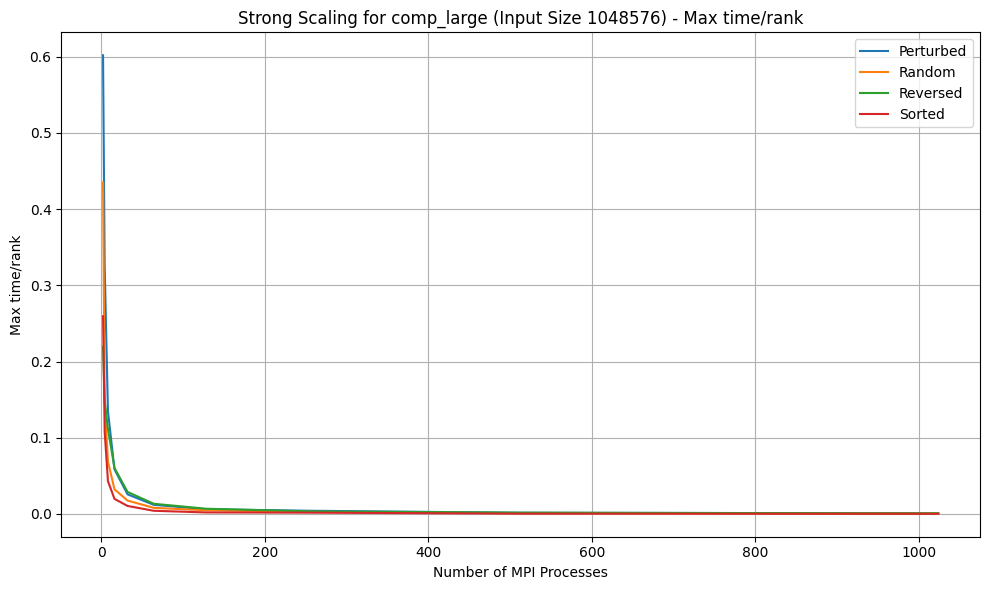

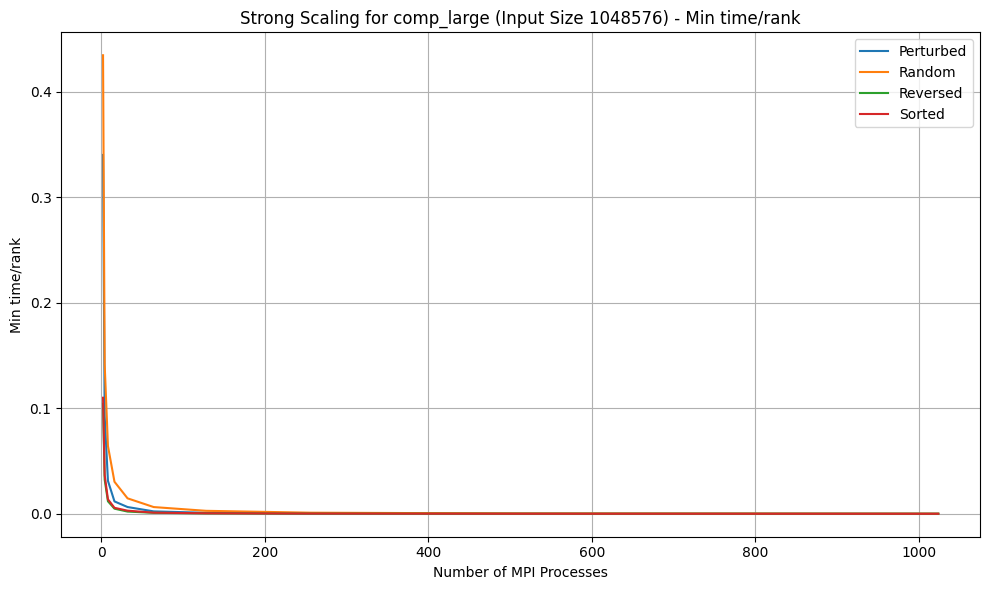

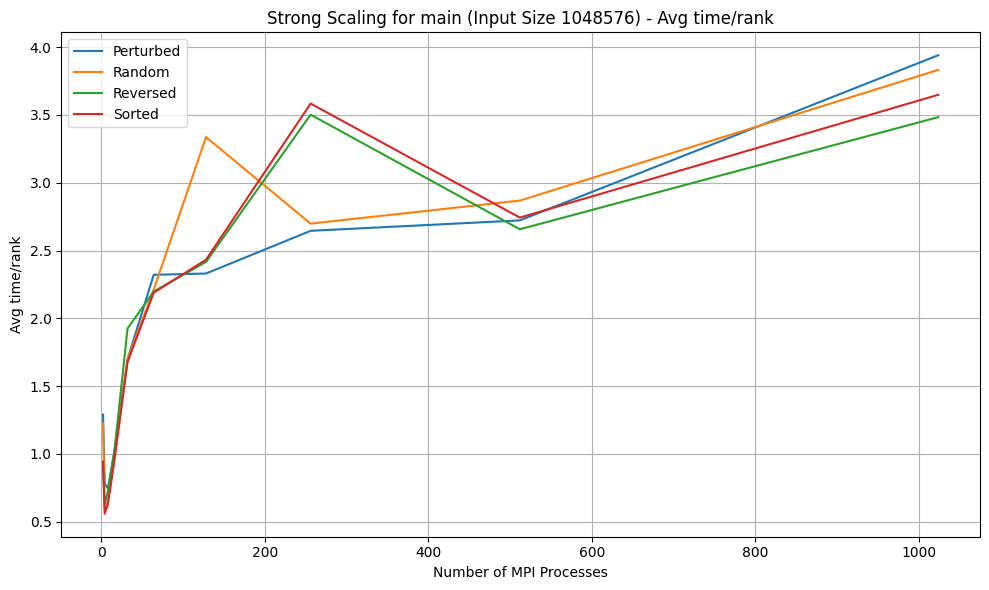

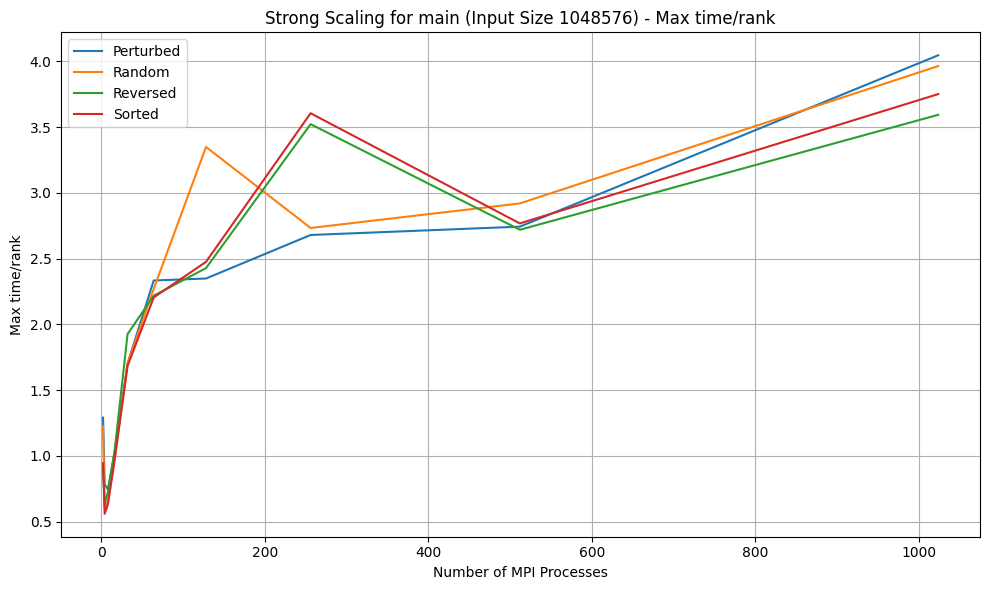

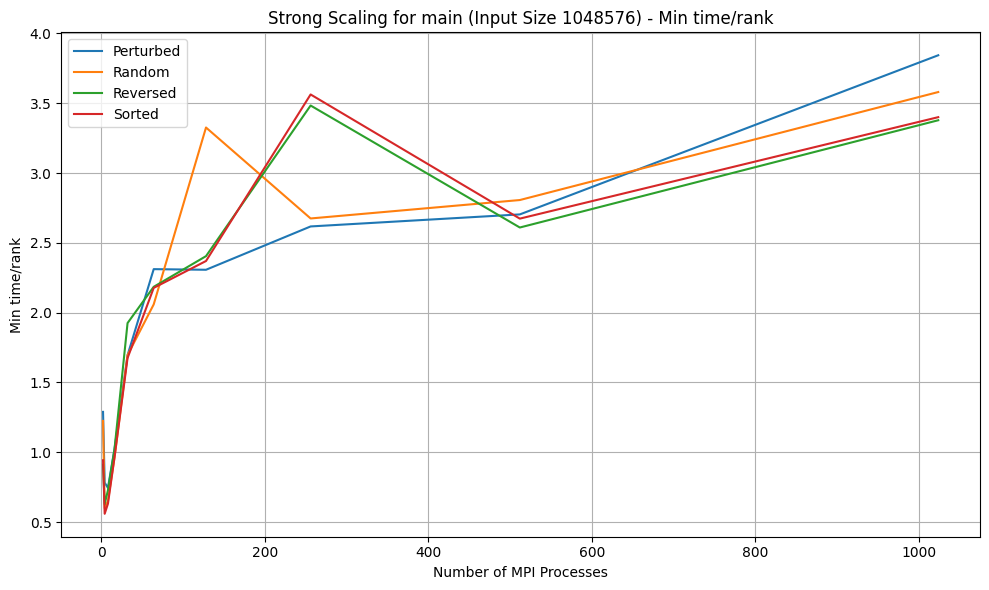

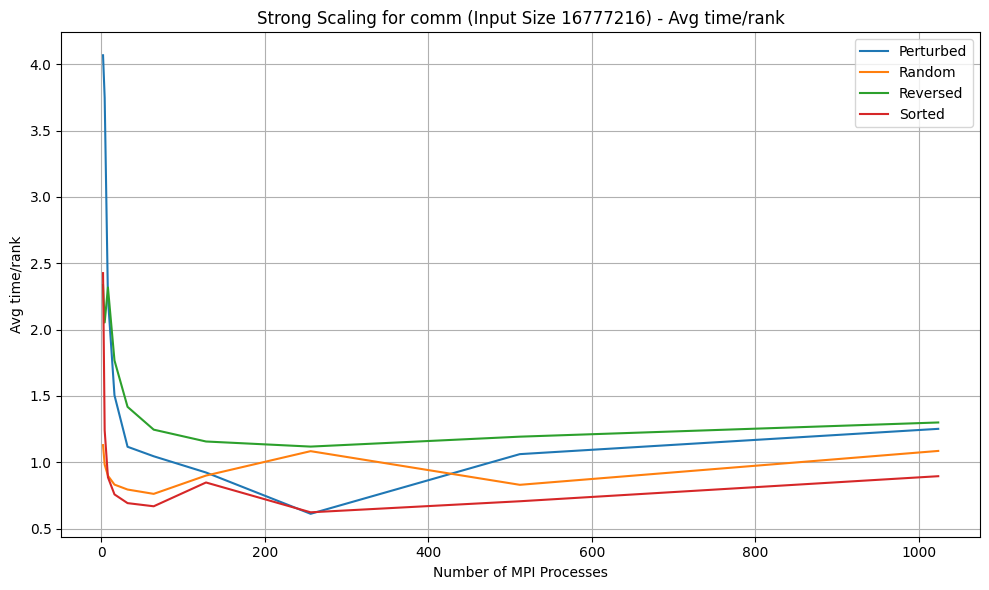

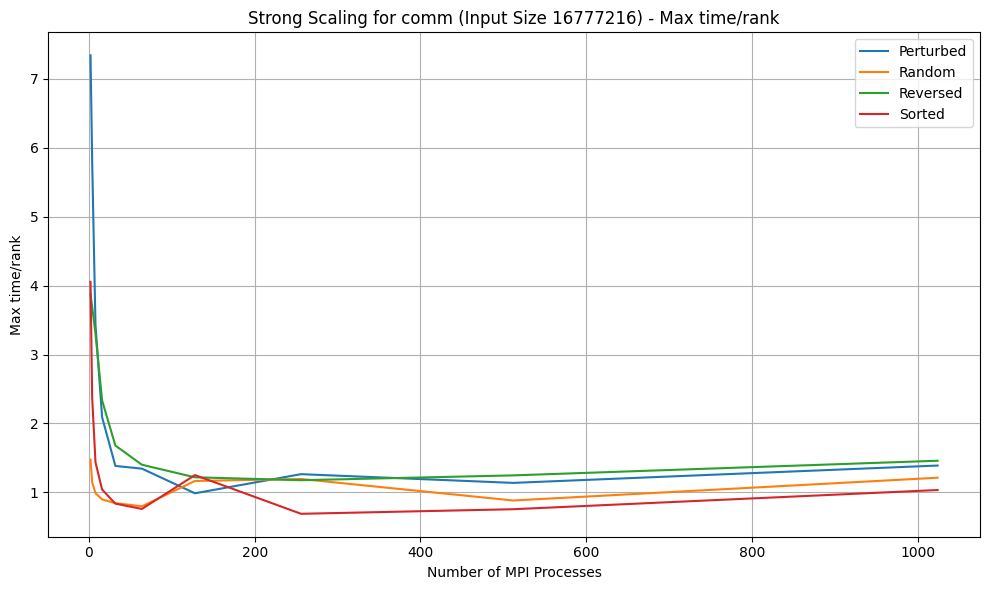

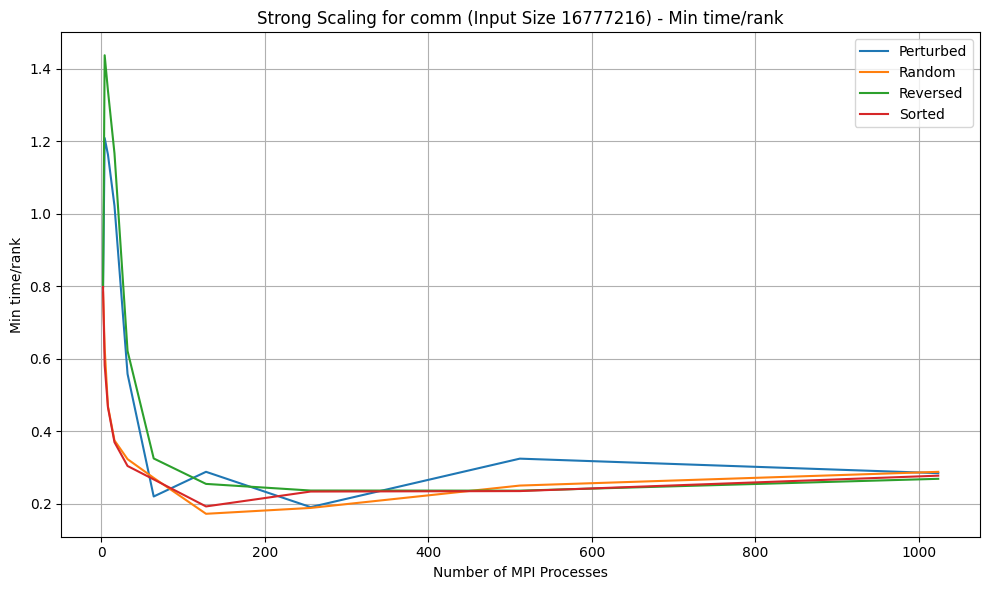

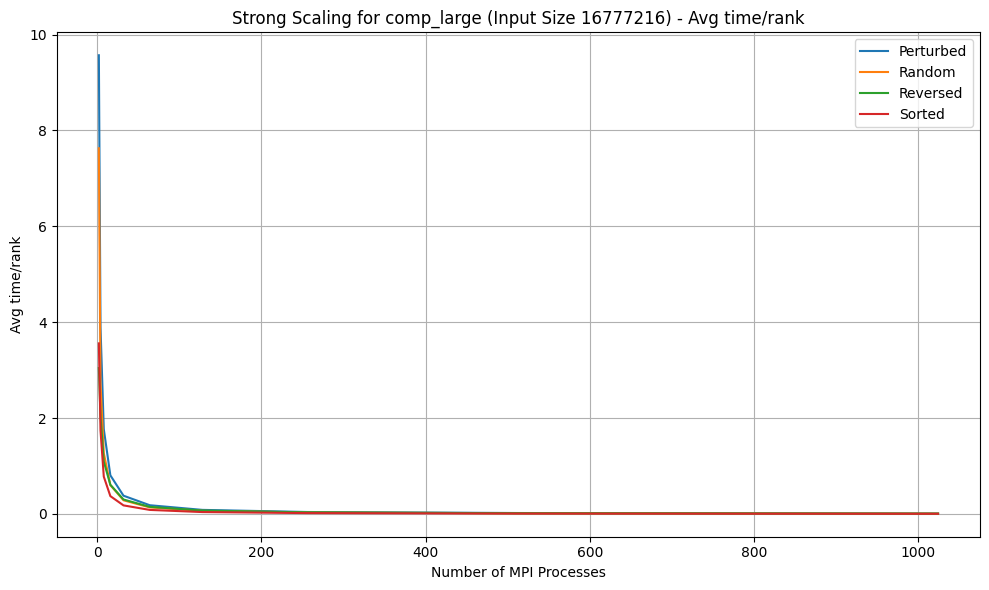

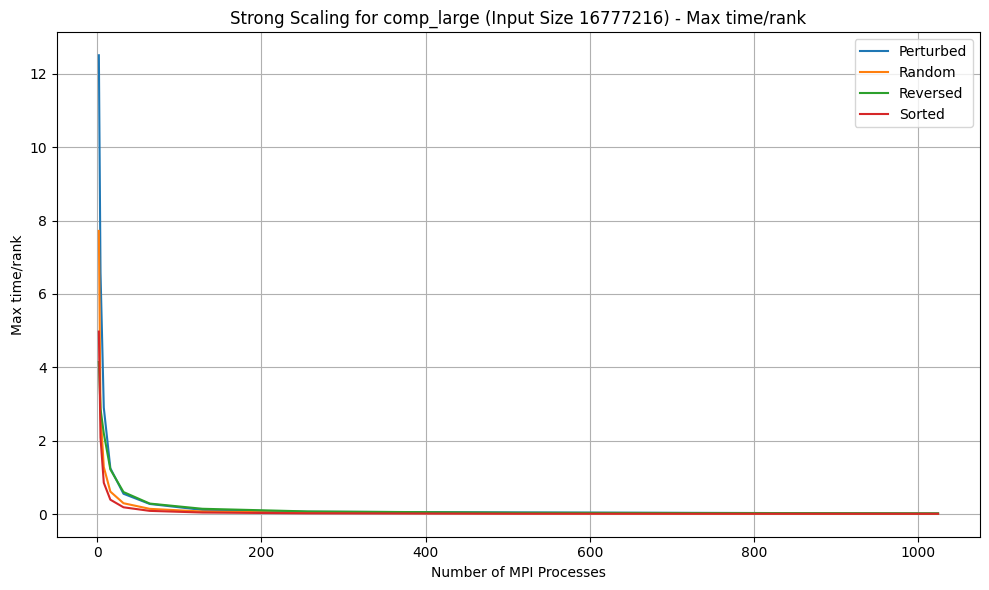

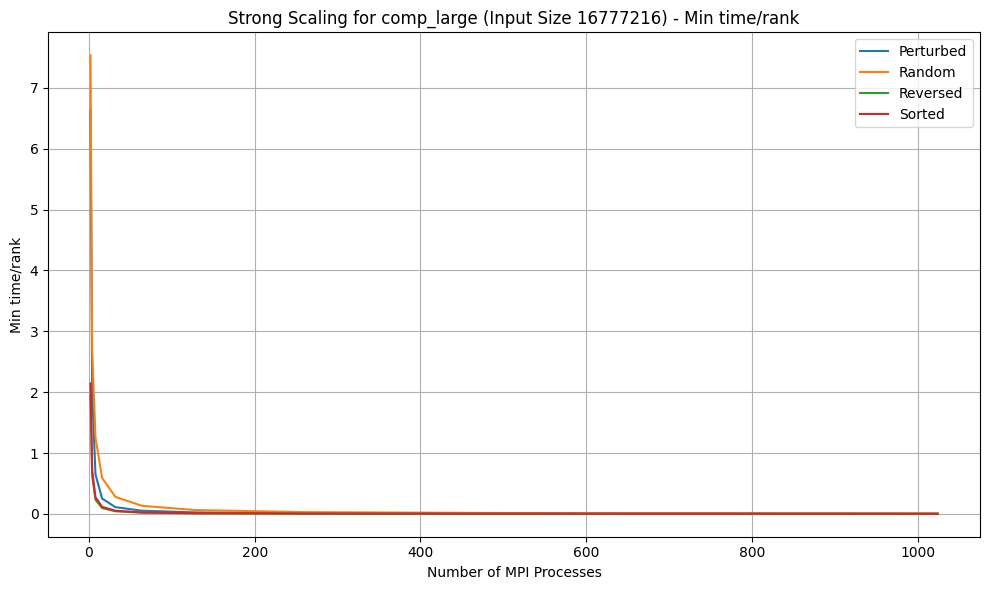

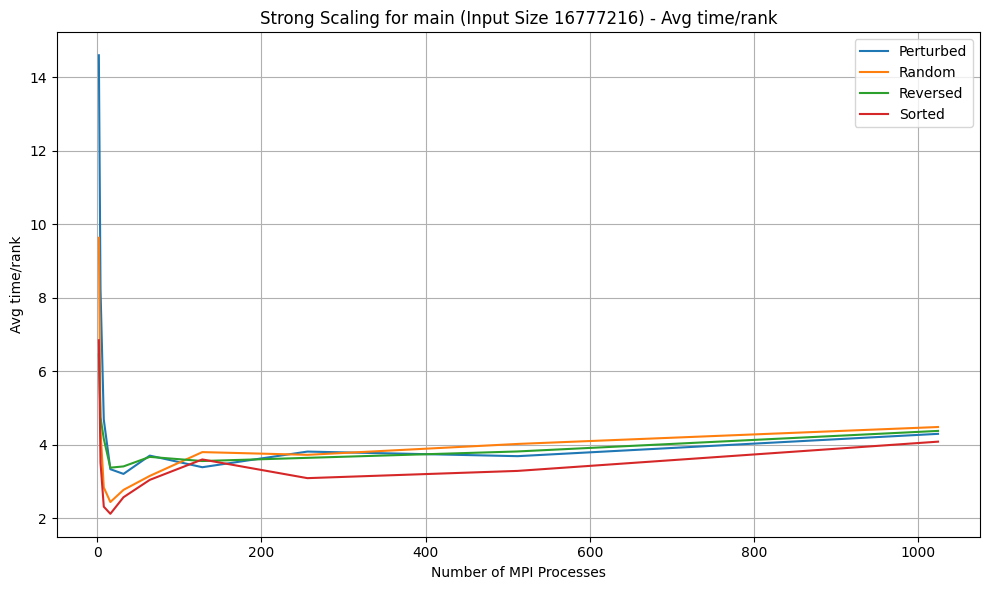

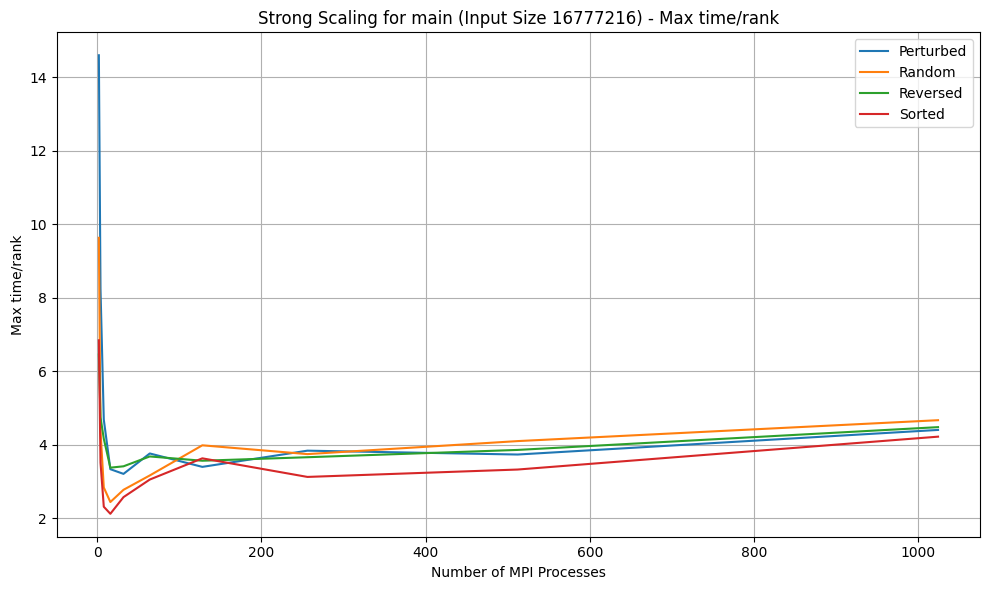

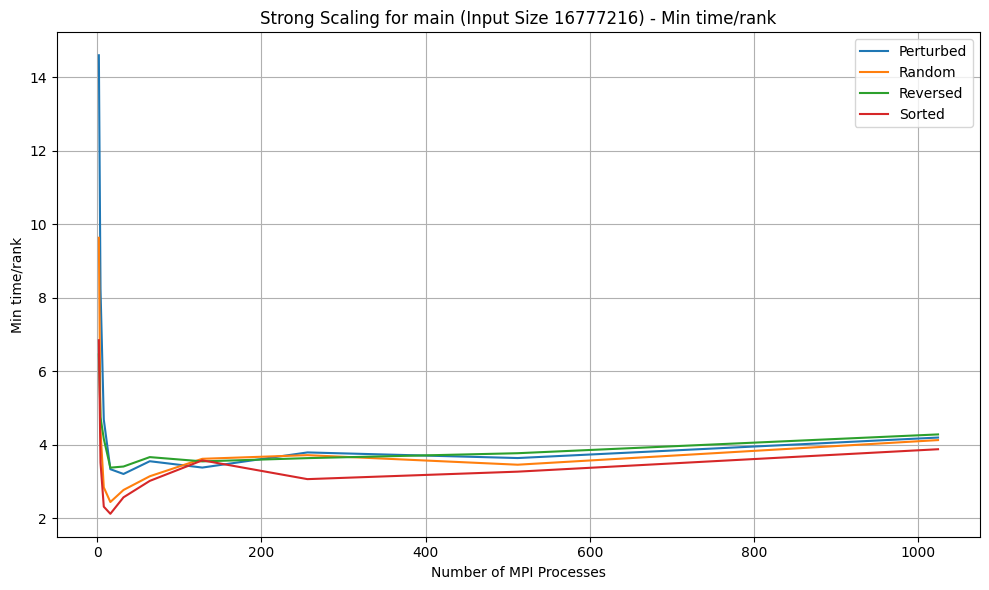

In [93]:
import matplotlib.pyplot as plt
import os

# Helper function to ensure the directory exists
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to plot strong scaling for each component and metric
def plot_strong_scaling_by_component(input_size, component, metric):
    plt.figure(figsize=(10, 6))
    
    # Loop through each input type
    for input_type, df in input_types_dataframes.items():
        # Filter the data for the current input_size and component (name)
        subset = df[(df['input_size'] == input_size) & (df['name'] == component)]
        if not subset.empty:
            # Ensure numeric columns are used for mean calculation
            numeric_cols = subset.select_dtypes(include='number')
            aggregated_data = numeric_cols.groupby('num_procs').mean()
            plt.plot(aggregated_data.index, aggregated_data[metric], label=f'{input_type}')
    
    # Set labels and title
    plt.xlabel('Number of MPI Processes')
    plt.ylabel(metric)
    plt.title(f'Strong Scaling for {component} (Input Size {input_size}) - {metric}')
    plt.grid(True)
    plt.legend()

    # Set output directory and file name
    output_dir = "mergesort/strong_scaling"
    # ensure_dir(output_dir)  # Ensure the directory exists

    # Replace spaces and slashes in metric name to create a valid filename
    safe_metric = metric.replace(" ", "_").replace("/", "_")
    # filename = os.path.join(output_dir, f"StrongScaling_{component}_InputSize_{input_size}_{safe_metric}.png")

    # Save the plot
    plt.tight_layout()
    # plt.savefig(filename)  # Save the plot as PNG file
    plt.show()
    plt.close()

# Generate plots for each input size, component, and metric
input_sizes = df_perturbed['input_size'].unique()

for input_size in input_sizes:
    for component in components:
        for metric in metrics:
            plot_strong_scaling_by_component(input_size, component, metric)

In [35]:
# # Function to calculate speedup and plot strong scaling speedup for each component and metric
# def plot_strong_scaling_speedup_by_component(input_type, df, component, metric):
#     plt.figure(figsize=(10, 6))

#     # Unique input sizes and number of processes
#     input_sizes = df['input_size'].unique()
#     num_procs_list = df['num_procs'].unique()

#     # Calculate speedup for each input size
#     for input_size in input_sizes:
#         # Filter the data for the current input_size and component
#         subset = df[(df['input_size'] == input_size) & (df['name'] == component)].copy()

#         # Ensure that the selected metric is available and not null
#         if subset[metric].isnull().any():
#             print(f"Skipping input size {input_size} for input type {input_type} due to missing '{metric}'.")
#             continue
        
#         # Get the baseline time (for the minimum number of processes)
#         baseline_time = subset[subset['num_procs'] == min(num_procs_list)][metric].mean()

#         # Skip if baseline_time is zero or missing
#         if baseline_time == 0 or pd.isnull(baseline_time):
#             print(f"Skipping input size {input_size} for input type {input_type} due to zero or null baseline time for '{metric}'.")
#             continue

#         # Calculate speedup: baseline_time divided by the current time for each number of processes
#         subset['speedup'] = baseline_time / subset[metric]

#         # Drop duplicates based on 'num_procs' and 'input_size'
#         subset = subset.drop_duplicates(subset=['num_procs'])

#         # Plot one line per input size
#         if not subset.empty:
#             plt.plot(subset['num_procs'], subset['speedup'], label=f'Input Size: {input_size}')

#     # Set labels and title
#     plt.xlabel('Number of MPI Processes')
#     plt.ylabel('Speedup')
#     plt.title(f'Strong Scaling Speedup - {component} - {input_type} - {metric}')
#     plt.grid(True)
#     plt.legend()

#     # Save the plot
#     filename = f"{output_dir}/Speedup_{component}_{input_type}_{metric}.png"
#     ensure_dir(filename)
#     plt.savefig(filename)
#     plt.close()

# # Function to ensure the directory exists
# def ensure_dir(file_path):
#     directory = os.path.dirname(file_path)
#     if not os.path.exists(directory):
#         os.makedirs(directory)

# # Define components and metrics
# components = ['comp_large', 'comm', 'main']
# metrics = ['Min time/rank', 'Max time/rank', 'Avg time/rank']

# # Define input types and dataframes
# input_types_dataframes = {
#     'Perturbed': df_perturbed,
#     'Random': df_random,
#     'Reversed': df_reversed,
#     'Sorted': df_sorted
# }

# # Output directory for saving speedup plots
# output_dir = "scaling_plots/samplesort/strong_scaling_speedup"

# # Generate plots for each input type, component, and metric
# for input_type, df in input_types_dataframes.items():
#     for component in components:
#         for metric in metrics:
#             plot_strong_scaling_speedup_by_component(input_type, df, component, metric)


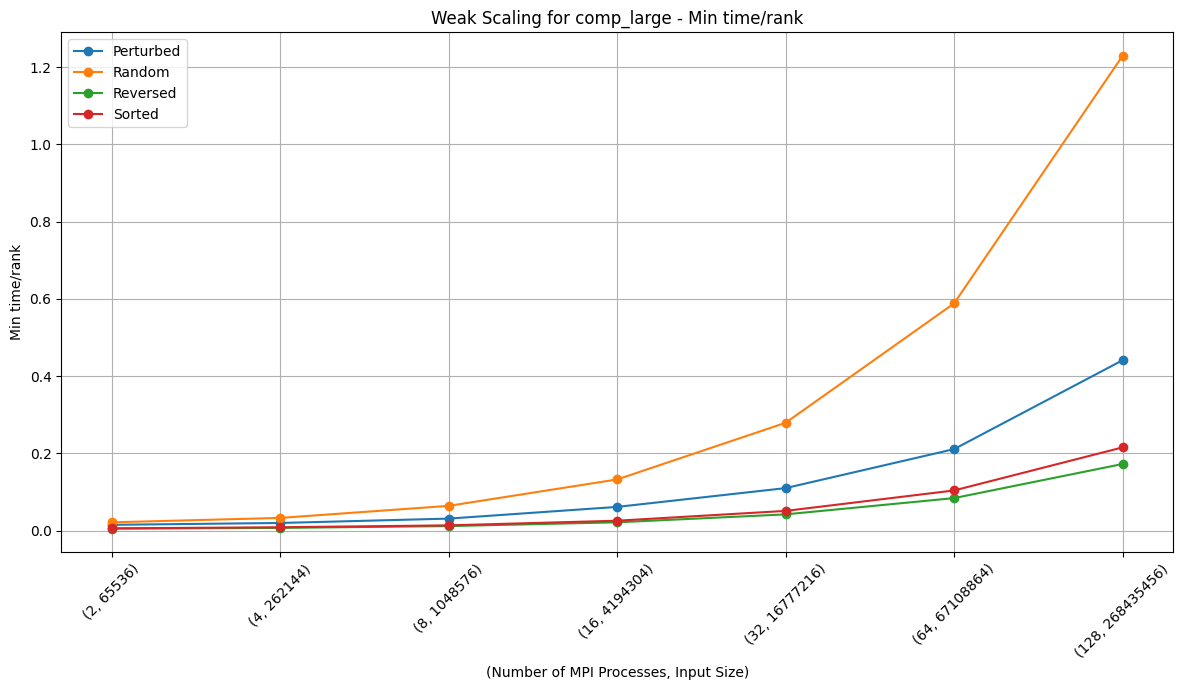

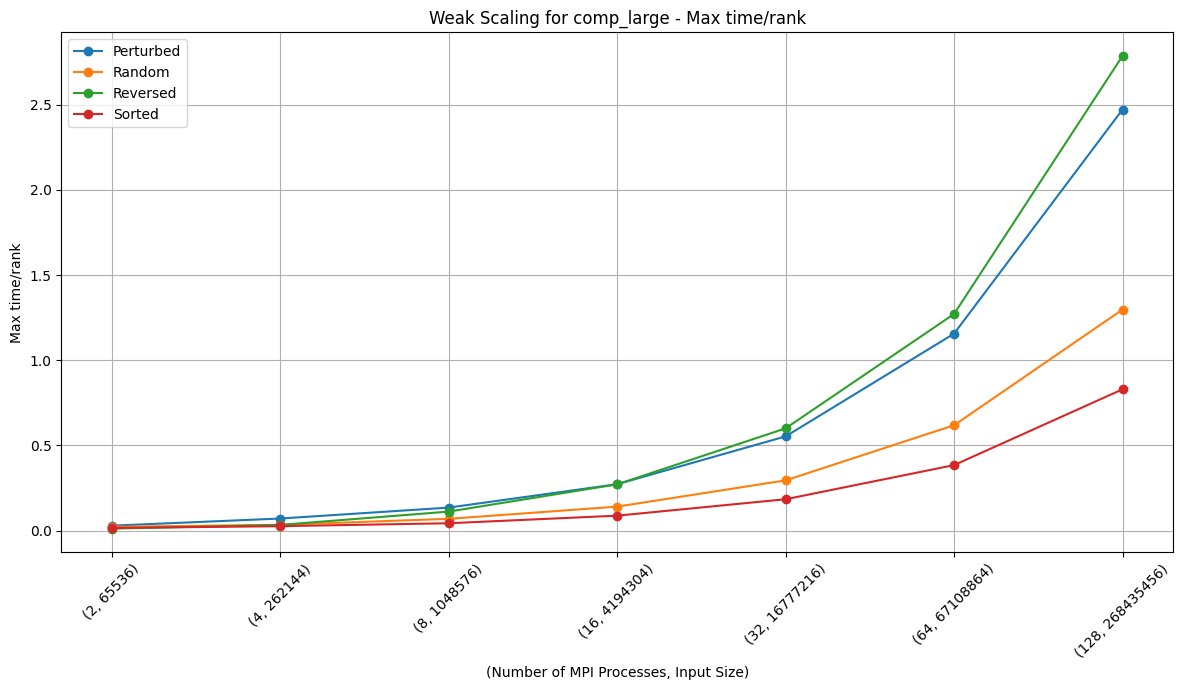

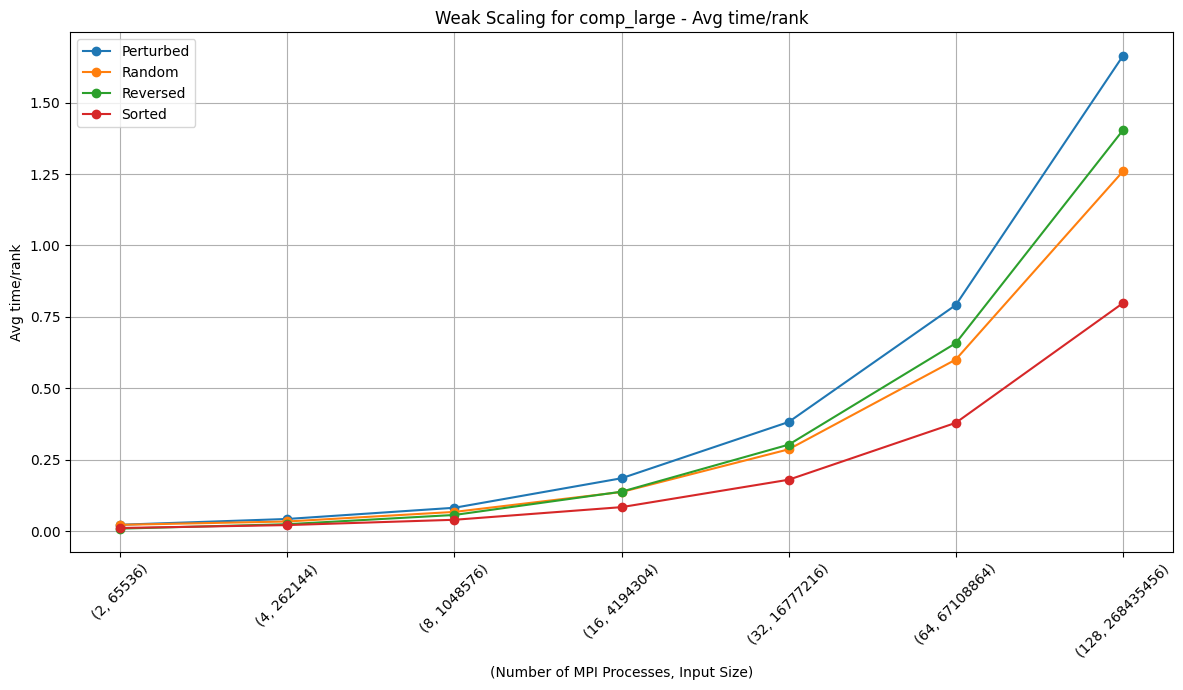

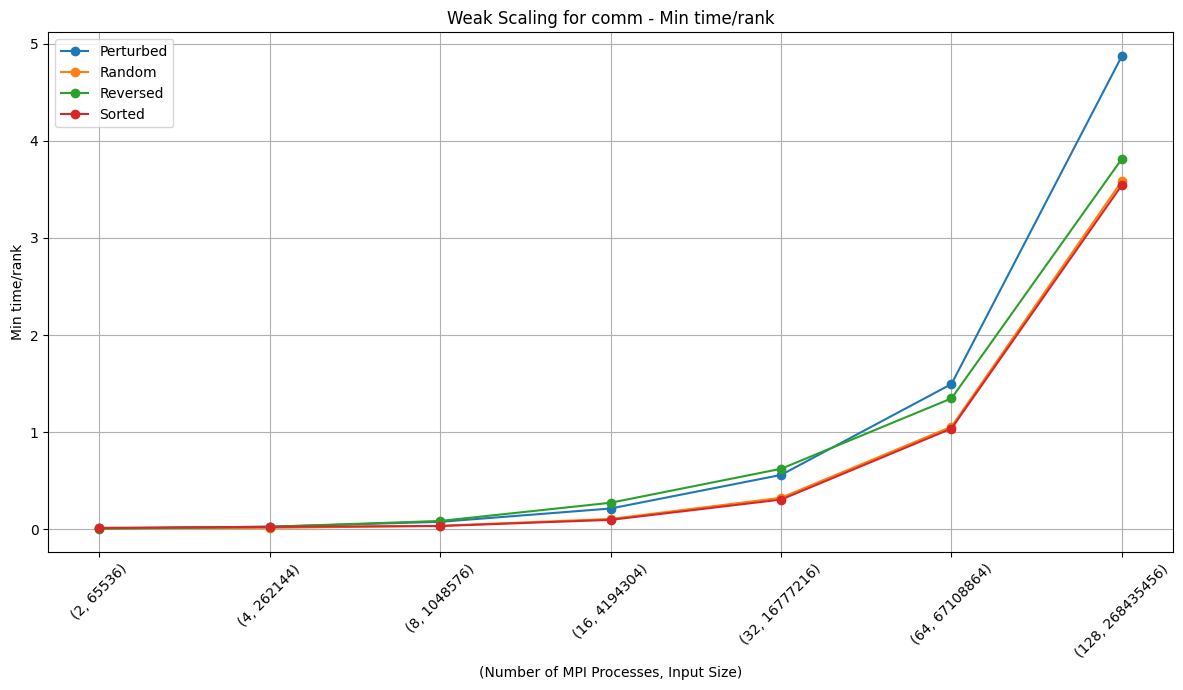

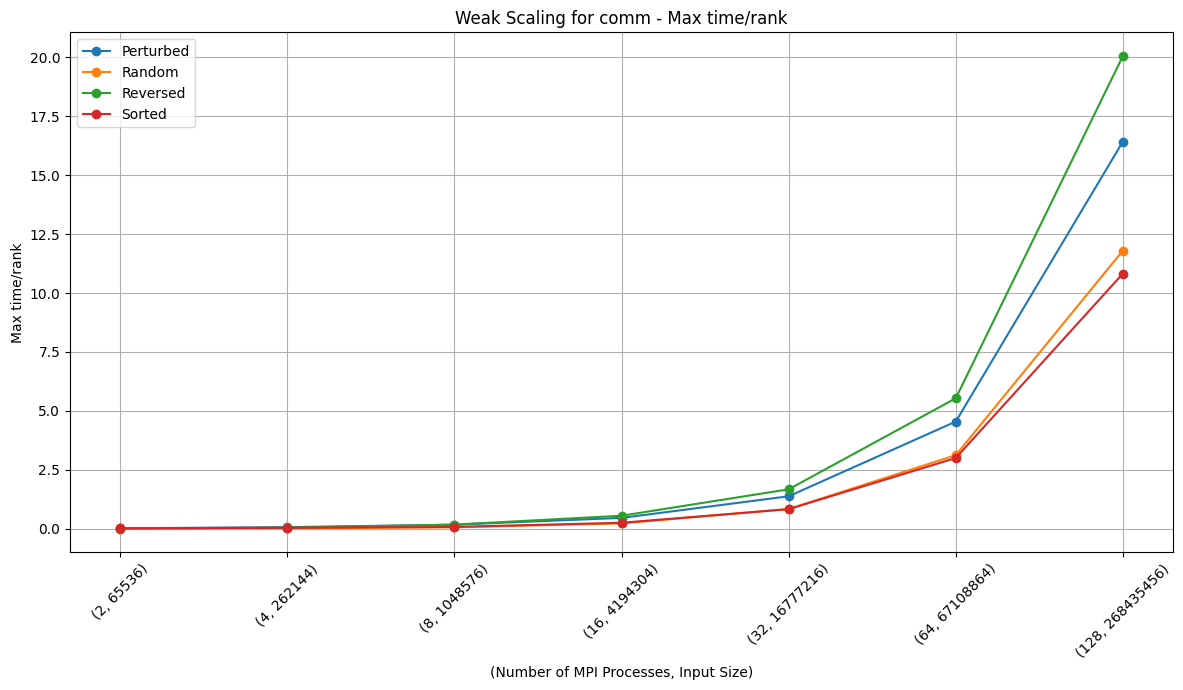

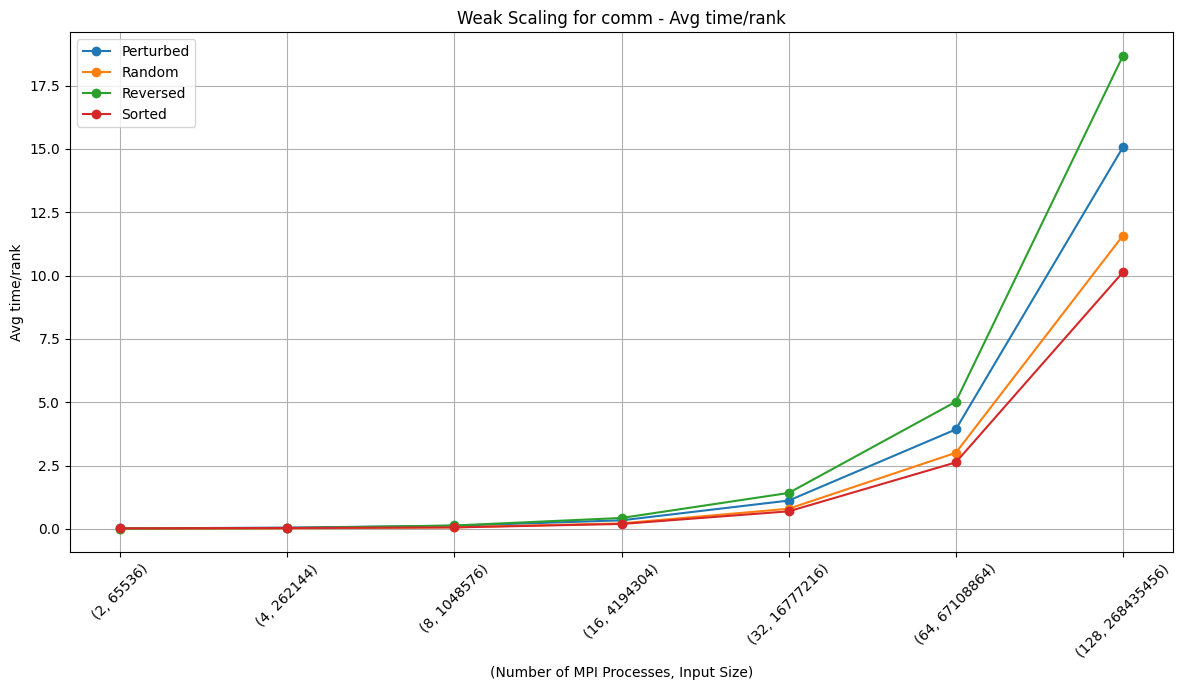

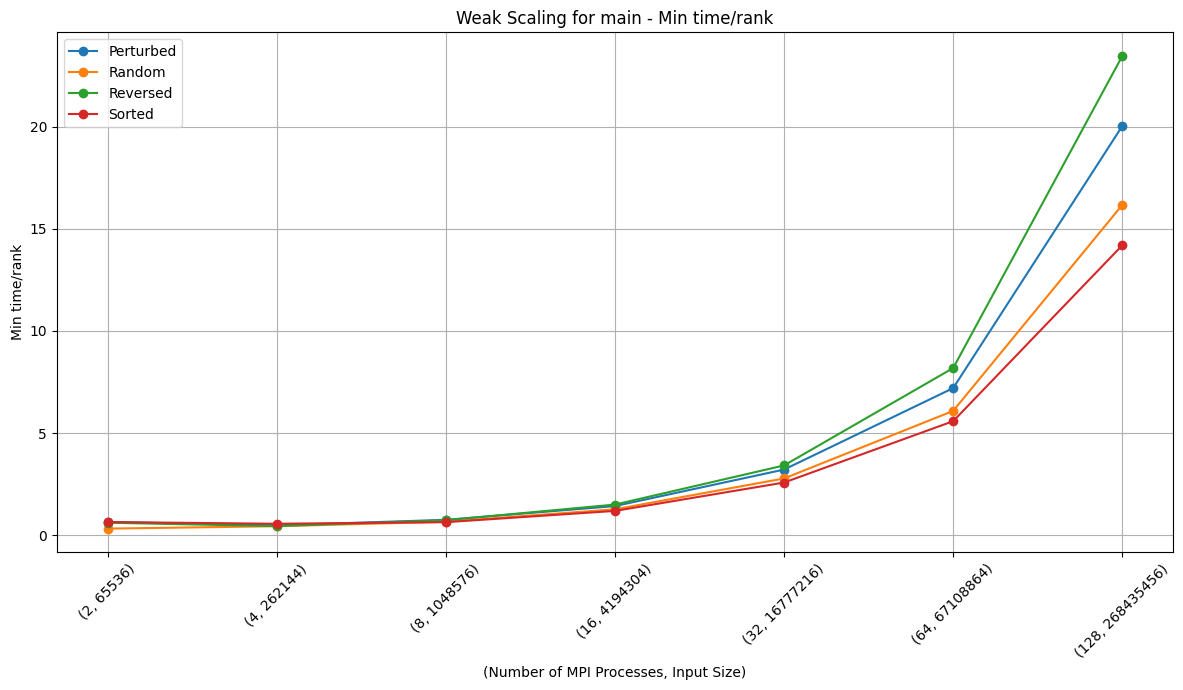

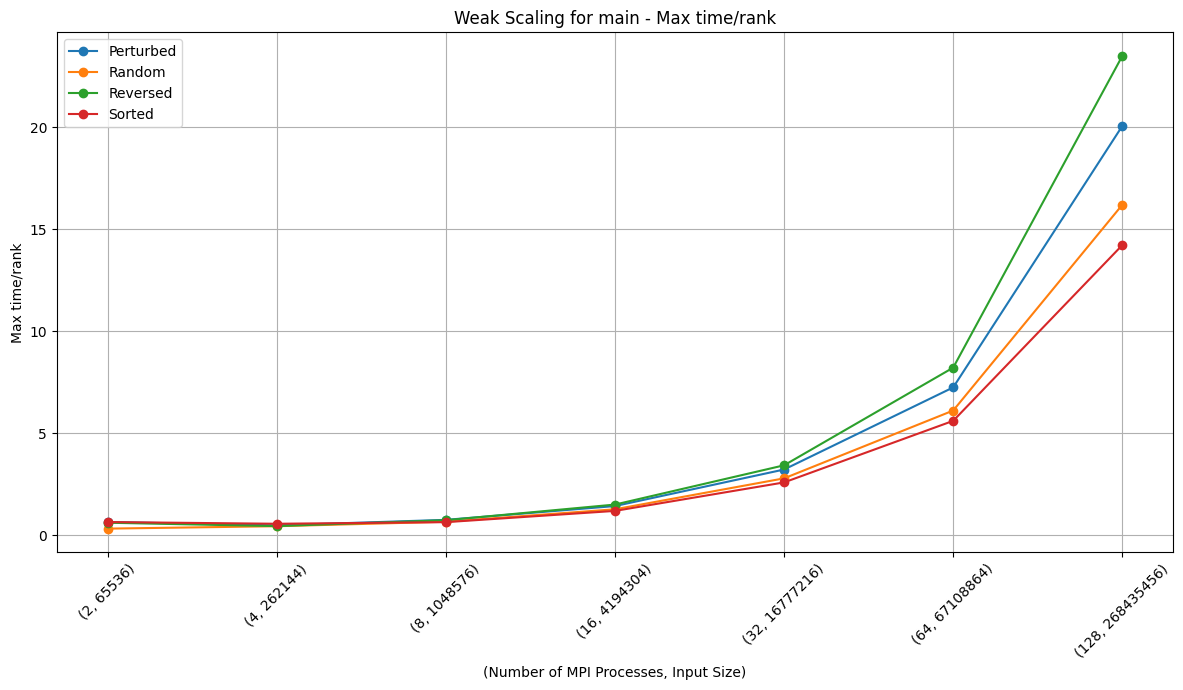

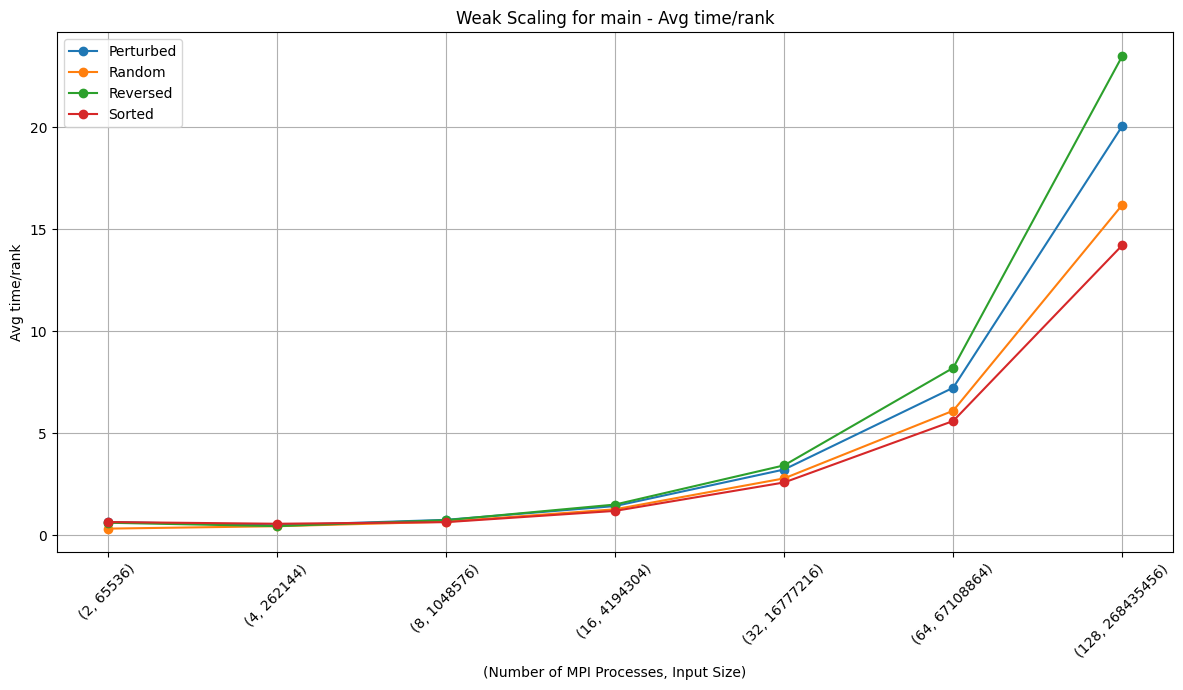

In [94]:
import matplotlib.pyplot as plt
import os

# Helper function to ensure the directory exists
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Function to plot weak scaling with proportional increase in input size and number of processes for each component and metric
def plot_weak_scaling_with_tuples(input_types_dataframes, component, metric):
    plt.figure(figsize=(12, 7))

    # Loop through each input type
    for input_type, df in input_types_dataframes.items():
        # Unique input sizes and number of processes
        input_sizes = sorted(df['input_size'].unique())
        num_procs_list = sorted(df['num_procs'].unique())

        # Initialize lists for x-axis tuples and y-axis times
        x_axis_labels = []
        y_values = []

        # Calculate weak scaling: increasing both input_size and num_procs proportionally
        for idx, input_size in enumerate(input_sizes):
            if idx >= len(num_procs_list):
                break
            
            num_procs = num_procs_list[idx]
            
            # Filter the data for the current input_size, num_procs, and component
            subset = df[(df['input_size'] == input_size) & (df['num_procs'] == num_procs) & (df['name'] == component)]

            # Check if data is available for the given metric
            if not subset.empty and subset[metric].notnull().all():
                x_axis_labels.append((num_procs, input_size))  # Tuple of (num_procs, input_size)
                y_values.append(subset[metric].mean())

        # Plot the results with tuples as x-axis labels
        plt.plot(range(len(x_axis_labels)), y_values, label=input_type, marker='o')

    # Convert the x-axis labels to tuples of (num_procs, input_size)
    x_axis_str_labels = [f"({procs}, {size})" for procs, size in x_axis_labels]
    plt.xticks(ticks=range(len(x_axis_str_labels)), labels=x_axis_str_labels, rotation=45)

    # Set labels and title
    plt.xlabel('(Number of MPI Processes, Input Size)')
    plt.ylabel(metric)
    plt.title(f'Weak Scaling for {component} - {metric}')
    plt.grid(True)
    plt.legend()

    # Set output directory and file name
    output_dir = "mergesort/weak_scaling"
    # ensure_dir(output_dir)  # Ensure the directory exists

    # Replace spaces and slashes in metric name to create a valid filename
    safe_metric = metric.replace(" ", "_").replace("/", "_")
    # filename = os.path.join(output_dir, f"WeakScaling_{component}_{safe_metric}.png")

    # Save the plot
    plt.tight_layout()
    # plt.savefig(filename)
    plt.show()
    plt.close()

# Define components, metrics, and input types
components = ['comp_large', 'comm', 'main']
metrics = ['Min time/rank', 'Max time/rank', 'Avg time/rank']

# Define input types and dataframes
input_types_dataframes = {
    'Perturbed': df_perturbed,
    'Random': df_random,
    'Reversed': df_reversed,
    'Sorted': df_sorted
}

# Generate weak scaling plots for each component and metric
for component in components:
    for metric in metrics:
        plot_weak_scaling_with_tuples(input_types_dataframes, component, metric)
